In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
from glob import glob
import matplotlib as mpl
import matplotlib.colors as mcolors

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
def combined_csv(directory, filter_fraction=None, knn=None):
    csv_files = glob(os.path.join(directory, '*.csv'))

    # Read and combine all CSVs
    dataframes = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Filter for desired methods
    methods = [
        'uniform', 'leverage', 'leverage_pca', 'rasp_leverage',
        'scsampler_coord', 'scsampler_transcriptomic', 'rasp_scsampler',
        'geo_coords', 'geo_transcriptomic', 'rasp_geo'
    ]
    combined_df = combined_df[combined_df['method'].isin(methods)]

    # Apply filters
    if filter_fraction is not None:
        combined_df = combined_df[combined_df['fraction'] == filter_fraction]

    if knn is not None:
        combined_df = combined_df[combined_df['knn_for_neighborhood_analysis'] == knn]

    return combined_df

def summarize_metrics_by_method(df,dataset = 'none specified',fraction = 0.1):
    """
    Summarizes selected metrics grouped by the 'method' column.

    Returns a DataFrame with:
    - One row per method
    - ari_recomputed_pca (non-null)
    - Median, 5% and 95% quantiles for transcriptomic_distance, coord_distance, pca_mean_diff
    """
    methods = df['method'].unique()
    summary = []

    for method in methods:
        group = df[df['method'] == method]

        ari = group['ari_recomputed_pca'].dropna().values
        ari_val = ari[0] if len(ari) > 0 else np.nan

        row = {
            'method': method,
            'ari_recomputed_pca': ari_val,
            'transcriptomic_distance_median': group['transcriptomic_distance'].median(),
            'transcriptomic_distance_5%': group['transcriptomic_distance'].quantile(0.05),
            'transcriptomic_distance_95%': group['transcriptomic_distance'].quantile(0.95),
            'coord_distance_median': group['coord_distance'].median(),
            'coord_distance_5%': group['coord_distance'].quantile(0.05),
            'coord_distance_95%': group['coord_distance'].quantile(0.95),
            'pca_mean_diff_median': group['pca_mean_diff'].median(),
            'pca_mean_diff_5%': group['pca_mean_diff'].quantile(0.05),
            'pca_mean_diff_95%': group['pca_mean_diff'].quantile(0.95),
            'dataset': dataset,
            'fraction': fraction
        }

        summary.append(row)

    return pd.DataFrame(summary)


def summarize_knn_by_method(df,dataset = 'none specified', fraction = 0.1):
    methods = df['method'].unique()
    summary = []

    for method in methods:
        group = df[df['method'] == method]

        

        row = {
            'method': method,
            'mse_median': group['mse'].median(),
            'mse_5%': group['mse'].quantile(0.05),
            'mse_95%':group['mse'].quantile(0.95),
            'cosine_median': group['mean_cosine_similarity'].median(),
            'cosine_5%': group['mean_cosine_similarity'].quantile(0.05),
            'cosine_95%': group['mean_cosine_similarity'].quantile(0.95),

            'jsd_median': group['mean_jsd'].median(),
            'jsd_5%': group['mean_jsd'].quantile(0.05),
            'jsd_95%': group['mean_jsd'].quantile(0.95),

            'fro_median': group['frobenius_norm'].median(),
            'fro_5%': group['frobenius_norm'].quantile(0.05),
            'fro_95%': group['frobenius_norm'].quantile(0.95),
            'dataset': dataset,
            'fraction': fraction,
            
            
        }

        summary.append(row)

    return pd.DataFrame(summary)


def plot_summary(final_metrics, final_knn, dataset = 'allen_merfish_brain',background_color = '#ffffff'): 
    sub = final_metrics[final_metrics['dataset']==dataset]
    sub_knn = final_knn[final_knn['dataset']==dataset]
    

    
        
    
    method_order = [
        'scsampler_transcriptomic',
        'geo_transcriptomic',
        'leverage_pca',
        'leverage',
        'scsampler_coord',
        'geo_coords',
        'rasp_scsampler',
        'rasp_geo',
        'rasp_leverage',
        'uniform'
    ]
    # print(sub['method'].unique())
    # print(sub[sub['method']=='uniform'])
    fig, axes = plt.subplots(1, 5, figsize=(10, 30), sharey=True)
    #fig.patch.set_facecolor(background_color)
    for ax in axes: 
        ax.set_facecolor(background_color)
	#order the plots: 
    sub_ordered = sub.set_index('method').loc[method_order].reset_index()
    sub_knn_ordered = sub_knn.set_index('method').loc[method_order].reset_index()
    sub_ordered['1-ari'] = 1- sub_ordered['ari_recomputed_pca']
    # Plot 1: ARI Recomputed PCA
    sns.barplot(
        data=sub_ordered,
        x='1-ari',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[0],
        legend=False,order = method_order,edgecolor = 'black',linewidth = 2
    )
    axes[0].set_title('1 - ARI')
    axes[0].set_xlabel('1-ARI')
    axes[0].set_ylabel('')
    axes[0].set_yticklabels([])
    axes[0].grid(True, axis='x', alpha=0.5)

	# Plot 2: Transcriptomic Distance
    
    
    sns.barplot(
        data=sub_ordered,
        x='transcriptomic_distance_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[1],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[1].errorbar(
        sub_ordered['transcriptomic_distance_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['transcriptomic_distance_median'] - sub_ordered['transcriptomic_distance_5%'],
              sub_ordered['transcriptomic_distance_95%'] - sub_ordered['transcriptomic_distance_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[1].set_title('Transcriptomic Hausdorff Distance')
    axes[1].set_xlabel('Distance')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[1].grid(True, axis='x', alpha=0.5)
    
    # Plot 3: Coord Distance
    lower_coord = sub['coord_distance_5%']
    upper_coord = sub['coord_distance_95%'] 
    
    sns.barplot(
        data=sub_ordered,
        x='coord_distance_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[2],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[2].errorbar(
        sub_ordered['coord_distance_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['coord_distance_median']-sub_ordered['coord_distance_5%'],
             sub_ordered['coord_distance_95%']-sub_ordered['coord_distance_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2
    )
    
    axes[2].set_title('Coordinate Hausdorff Distance')
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('')
    axes[2].set_yticks(range(len(method_order)))
    axes[2].set_yticklabels(method_order)
    axes[2].grid(True, axis='x', alpha=0.5)
    
    
    
    #plot 4: pca difference 
    lower_pca =  sub['pca_mean_diff_5%']
    upper_pca = sub['pca_mean_diff_95%'] 
    
    sns.barplot(
        data=sub_ordered,
        x='pca_mean_diff_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[3],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[3].errorbar(
        sub_ordered['pca_mean_diff_median'],
        range(len(sub_ordered)),
        xerr=[sub_ordered['pca_mean_diff_median']-sub_ordered['pca_mean_diff_5%'], 
              sub_ordered['pca_mean_diff_95%']-sub_ordered['pca_mean_diff_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[3].set_title('Sketch vs Full PCA')
    axes[3].set_xlabel('Difference')
    axes[3].set_ylabel('')
    axes[3].set_yticks(range(len(method_order)))
    axes[3].set_yticklabels(method_order)
    axes[3].grid(True, axis='x', alpha=0.5)
    
    
    
    
    #plot 4: local neighborhood difference 
    lower_mse = sub_knn['mse_5%']
    upper_mse= sub_knn['mse_95%'] 
    
    sns.barplot(
        data=sub_knn_ordered,
        x='mse_median',
        y='method',
        hue='method',
        palette=color_dict,
        width=0.6,
        ax=axes[4],
        legend=False,
        errorbar=None,order = method_order,
        err_kws={'linewidth': 1.5},edgecolor = 'black',linewidth = 2
    )
    
    axes[4].errorbar(
        sub_knn_ordered['mse_median'],
        range(len(sub_knn_ordered)),
        xerr=[sub_knn_ordered['mse_median']-sub_knn_ordered['mse_5%'], 
             sub_knn_ordered['mse_95%']-sub_knn_ordered['mse_median']],
        fmt='none',
        ecolor='black',
        capsize=3,
        elinewidth=2,
        capthick=2,
    )
    
    axes[4].set_title('Local distortion')
    axes[4].set_xlabel('mse')
    axes[4].set_ylabel('')
    axes[4].set_yticks(range(len(method_order)))
    axes[4].set_yticklabels(method_order)
    axes[4].grid(True, axis='x', alpha=0.5)

    
    
    
    
    
    plt.tight_layout()
    plt.show()
    
    return fig


    

In [48]:
#allen brain institute 
filter_fraction = 0.1
knn = 10
dataset = 'allen_merfish_brain'
directory1 = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/combined_metrics'
allen_brain_metrics = combined_csv(directory1,filter_fraction = filter_fraction)


#read in the specific knn neighborhood analysis file: 
directory2 = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/knn_neighborhood_analysis'
allen_knn_metrics = combined_csv(directory2,filter_fraction = filter_fraction, knn = knn)

allen_metrics_summary = summarize_metrics_by_method(allen_brain_metrics,dataset = dataset,fraction = filter_fraction)
allen_knn_summary = summarize_knn_by_method(allen_knn_metrics,dataset=dataset,fraction = filter_fraction)

#allen brain institute 
filter_fraction = 0.1
knn = 10
dataset = 'mouse_ovary_merfish'
directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH/sketching_test/combined_metrics'
allen_brain_metrics = combined_csv(directory,filter_fraction = filter_fraction)


#read in the specific knn neighborhood analysis file: 
directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/allen_institute_data/sketching_test/knn_neighborhood_analysis'
allen_knn_metrics = combined_csv(directory,filter_fraction = filter_fraction, knn = knn)

allen_metrics_summary = summarize_metrics_by_method(allen_brain_metrics,dataset = dataset,fraction = filter_fraction)
allen_knn_summary = summarize_knn_by_method(allen_knn_metrics,dataset=dataset,fraction = filter_fraction)





In [4]:
#lets combine all the metrics for all the datasets 
# we will only be taking the 0.1 sketching fraction to compare in our 
# summary figure 

base = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data"

datasets_info = [
    (
        os.path.join(base, 'allen_institute_data/sketching_test/combined_metrics'),
        os.path.join(base,'allen_institute_data/sketching_test/knn_neighborhood_analysis'),
        'allen_merfish_brain'
    ),
    (
        os.path.join(base, 'mouse_MERFISH_data/sketching_test/combined_metrics'),
        os.path.join(base,'mouse_MERFISH_data/sketching_test/knn_neighborhood_metrics'),
        'mouse_ovary_merfish'
    ),
    (
        os.path.join(base, 'visium_HD_brain/sketching_test/combined_metrics'),
        os.path.join(base,'visium_HD_brain/sketching_test/knn_neighborhood_analysis'),
        'visium_HD_brain'
    ),
    (
        os.path.join(base, 'xenium_cancer/sketching_test/combined_metrics'),
        os.path.join(base,'xenium_cancer/sketching_test/knn_neighborhood_analysis'),
        'xenium_cancer'
    ),
    (
        os.path.join(base, 'xenium_lung/sketching_test/combined_metrics'),
        os.path.join(base,'xenium_lung/sketching_test/knn_neighborhood_analysis'),
        'xenium_lung'
    ),
    (
        os.path.join(base, 'simulations_for_sketching_analysis/visium_like_data/complex/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/visium_like_data/complex/sketching_test/knn_neighborhood_analysis'),
        'visium_like_complex'
    ),
                     (
        os.path.join(base, 'simulations_for_sketching_analysis/visium_like_data/radial/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/visium_like_data/radial/sketching_test/knn_neighborhood_analysis'),
        'visium_like_radial'
    ),
                     (
        os.path.join(base, 'simulations_for_sketching_analysis/visium_like_data/stripes/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/visium_like_data/stripes/sketching_test/knn_neighborhood_analysis'),
        'visium_like_stripes'
    ),
                     (
        os.path.join(base, 'simulations_for_sketching_analysis/xenium_like_data/complex/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/xenium_like_data/complex/sketching_test/knn_neighborhood_analysis'),
        'xenium_like_complex'
    ),
                     (
        os.path.join(base, 'simulations_for_sketching_analysis/xenium_like_data/radial/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/xenium_like_data/radial/sketching_test/knn_neighborhood_analysis'),
        'xenium_like_radial'
    ),
                     (
        os.path.join(base, 'simulations_for_sketching_analysis/xenium_like_data/stripes/sketching_test/combined_metrics'),
        os.path.join(base,'simulations_for_sketching_analysis/xenium_like_data/stripes/sketching_test/knn_neighborhood_analysis'),
        'xenium_like_stripes'
    )]

In [5]:
#initialize and set the filter and knn values

all_metrics_summaries = []
all_knn_summaries = []

filter_fraction = 0.1
knn = 10


#now lets pull in the metrics 
for directory1, directory2, dataset in datasets_info:
    print(f"processing dataset: {dataset}")
    # Load and filter main metrics
    summary_metrics = combined_csv(directory1, filter_fraction=filter_fraction)
    knn_metrics = combined_csv(directory2, filter_fraction=filter_fraction, knn=knn)

    # Summarize and store
    summary_metrics = summarize_metrics_by_method(summary_metrics, dataset=dataset, fraction=filter_fraction)
    summary_knn = summarize_knn_by_method(knn_metrics)

    # Add dataset + fraction columns for context
    summary_metrics['dataset'] = dataset
    summary_metrics['fraction'] = filter_fraction

    summary_knn['dataset'] = dataset
    summary_knn['fraction'] = filter_fraction

    # Store
    all_metrics_summaries.append(summary_metrics)
    all_knn_summaries.append(summary_knn)

processing dataset: allen_merfish_brain
processing dataset: mouse_ovary_merfish
processing dataset: visium_HD_brain
processing dataset: xenium_cancer
processing dataset: xenium_lung
processing dataset: visium_like_complex
processing dataset: visium_like_radial
processing dataset: visium_like_stripes
processing dataset: xenium_like_complex
processing dataset: xenium_like_radial
processing dataset: xenium_like_stripes


In [12]:
#combine all the summaries into one df 
final_metrics_df = pd.concat(all_metrics_summaries, ignore_index=True)
final_knn_df = pd.concat(all_knn_summaries, ignore_index=True)


In [78]:
#save 
# final_metrics_df.to_csv(os.path.join(base,"10%_sketching_summary_all_datasets.csv"),index = False)
# final_knn_df.to_csv(os.path.join(base,"10%_sketching_knn_summary_all_datasets.csv"),index = False)

In [13]:
base = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data"
#note, we were missing a few values for the ARI, must have not gotten all the batch scripts full executed. 
#fixing now 
final_metrics_df = pd.read_csv(os.path.join(base,"10%_sketching_summary_all_datasets.csv"))
final_knn_df = pd.read_csv(os.path.join(base,"10%_sketching_knn_summary_all_datasets.csv"))

In [17]:
all_methods = [
    'uniform', 'leverage', 'leverage_pca','rasp_leverage',
    'scsampler_coord', 'scsampler_transcriptomic', 'rasp_scsampler', 
    'geo_coords', 'geo_transcriptomic', 'rasp_geo'
]

# Get 'Set2' colors for the methods
palette = sns.color_palette("Set2", len(all_methods))

# Create the color mapping
color_dict = dict(zip(all_methods, palette))

# Update the last method's color to the specified hex
color_dict[all_methods[-2]] = "#bc80bd"
color_dict[all_methods[-1]] = "#80b1d3"



# Check the color mapping
for method, color in color_dict.items():
    print(f'Method: {method}, Color: {color}')



Method: uniform, Color: (0.4, 0.7607843137254902, 0.6470588235294118)
Method: leverage, Color: (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
Method: leverage_pca, Color: (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
Method: rasp_leverage, Color: (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
Method: scsampler_coord, Color: (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
Method: scsampler_transcriptomic, Color: (1.0, 0.8509803921568627, 0.1843137254901961)
Method: rasp_scsampler, Color: (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)
Method: geo_coords, Color: (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)
Method: geo_transcriptomic, Color: #bc80bd
Method: rasp_geo, Color: #80b1d3


In [3]:
import matplotlib as mpl


In [3]:
#combine all the files together
#combine csv files first: 
import glob as glob
def combine_csv_files_by_fraction(input_dir, output_dir):
    # Ensure the output directory exists
    #os.makedirs(output_dir, exist_ok=True)
    
    # Get a list of all CSV files following the naming convention
    csv_files = glob.glob(os.path.join(input_dir, 'index_seed_*.csv'))
    
    # A dictionary to store DataFrames grouped by the fraction value
    fraction_file_dict = {}
    
    # Process each file
    for file_path in csv_files:
        # Extract the fraction from the file name
        file_name = os.path.basename(file_path)
        split_name = file_name.split('_')
        # Convert from string to float
        fraction = float(split_name[-1].replace('.csv', ''))
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Group by the fraction
        if fraction not in fraction_file_dict:
            fraction_file_dict[fraction] = [df]
        else:
            fraction_file_dict[fraction].append(df)
    
    # Write out the concatenated files by fraction
    for fraction, dfs in fraction_file_dict.items():
        # Concatenate all DataFrames for this fraction
        combined_df = pd.concat(dfs, ignore_index=False,axis=1)
        
        # Define the output file name
        output_file_name = f'index_{fraction:.2f}.csv'
        output_file_path = os.path.join(output_dir, output_file_name)
        
        # Save to a CSV file
        print(combined_df)
        combined_df.to_csv(output_file_path, index=False)

In [5]:
#we need to save all the files to combined dir (index files): 
parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/sketching_test/index'

input_dir = os.path.join(parent_dir,'leverage_index/archive')
output_dir = os.path.join(parent_dir,'leverage_index')

combine_csv_files_by_fraction(input_dir, output_dir)

        seed_2  seed_0  seed_7  seed_5  seed_9  seed_8  seed_3  seed_1  \
0            0       0       0       0       0       0       0       1   
1            1       1       1       2       1       1       2       3   
2            2       2       2       3       3       2       3       4   
3            3       3       3       4       4       3       4       7   
4            4       4       4       5       5       4       9       8   
...        ...     ...     ...     ...     ...     ...     ...     ...   
452727  565907  565908  565906  565908  565908  565907  565911  565909   
452728  565908  565909  565908  565910  565909  565908  565912  565910   
452729  565909  565910  565910  565911  565912  565910  565913  565912   
452730  565910  565912  565911  565912  565913  565912  565914  565914   
452731  565912  565915  565912  565913  565915  565913  565915  565915   

        seed_6  seed_4  
0            2       0  
1            3       3  
2            4       4  
3          

Below is the updated code for the figure 2 summary. 
We are using heatmaps to display the data instead of barcharts, 
and we have updated the summary .csv file manually so that the 10% sketjching summary also has the mse data as well. 


In [3]:
base = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data"
#note, we were missing a few values for the ARI, must have not gotten all the batch scripts full executed. 
#fixing now 
final_metrics_df = pd.read_csv(os.path.join(base,"10%_sketching_summary_all_datasets.csv"))
final_metrics_df

,method,ari_recomputed_pca,transcriptomic_distance_median,transcriptomic_distance_5%,transcriptomic_distance_95%,coord_distance_median,coord_distance_5%,coord_distance_95%,pca_mean_diff_median,pca_mean_diff_5%,pca_mean_diff_95%,mse_median,mse_5%,mse_95%,dataset,fraction
0,rasp_geo,0.625529,12.763828,12.682838,12.905536,0.208678,0.193842,0.255151,8.807002,8.751383,8.879612,0.006254,0.006156,0.006334,allen_merfish_brain,0.1
1,rasp_scsampler,0.595452,12.459712,12.304991,12.553196,0.185167,0.174278,0.194407,7.885367,7.515398,7.958989,0.007176,0.007063,0.007278,allen_merfish_brain,0.1
2,rasp_leverage,0.835317,12.898687,12.791933,12.997734,0.194712,0.185505,0.210323,9.474865,8.591629,10.217125,0.005172,0.005003,0.005295,allen_merfish_brain,0.1
3,leverage_pca,0.831450,12.898956,12.849196,13.006442,0.199373,0.186304,0.206507,9.625182,9.245345,9.946580,0.005186,0.005061,0.005241,allen_merfish_brain,0.1
4,geo_coords,0.763349,12.925204,12.824427,12.979510,0.110002,0.104947,0.113690,5.736105,5.366111,6.634837,0.005060,0.005011,0.005156,allen_merfish_brain,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,uniform,0.109934,15.539207,15.526062,15.550176,0.032780,0.031036,0.035264,4.071014,3.933854,4.378466,0.002844,0.002705,0.003050,xenium_like_stripes,0.1
106,rasp_geo,0.097374,15.544992,15.532305,15.560776,0.047133,0.044731,0.051153,4.338673,4.012293,4.423198,0.003266,0.003091,0.003366,xenium_like_stripes,0.1
107,rasp_scsampler,0.061896,15.547555,15.519084,15.565965,0.055514,0.051824,0.060126,4.344074,4.102007,4.459826,0.003380,0.003309,0.003710,xenium_like_stripes,0.1
108,rasp_leverage,0.122403,15.546234,15.533808,15.557259,0.032643,0.030666,0.035990,3.991341,3.934300,4.527601,0.002898,0.002773,0.003149,xenium_like_stripes,0.1


In [6]:
def normalize_group(group):
    group = group.copy()
    for col in all_metrics:
        if group[col].max() == group[col].min():
            group[col+'_norm'] = 0.0
        elif col == 'ari_recomputed_pca':
            group[col+'_norm'] = (group[col] - group[col].min()) / (group[col].max() - group[col].min())
        else:
            group[col+'_norm'] = 1 - (group[col] - group[col].min()) / (group[col].max() - group[col].min())
    # Only spatial metrics for overall
    group['overall_spatial_score'] = group[[col+'_norm' for col in spatial_metrics]].mean(axis=1)
    return group

def rank_group(group):
    group = group.copy()
    for col in all_metrics:
        if col == 'ari_recomputed_pca':
            group[col+'_rank'] = group[col].rank(method='min', ascending=False)
        else:
            group[col+'_rank'] = group[col].rank(method='min', ascending=True)
    # Only spatial metrics for rank sum
    group['overall_spatial_rank'] = group[[col+'_rank' for col in spatial_metrics]].sum(axis=1)
    return group

def scale_overall_score(group):
    min_score = group['overall_score'].min()
    max_score = group['overall_score'].max()
    if max_score == min_score:
        group['overall_score_scaled'] = 0.0  # or np.nan if you prefer
    else:
        group['overall_score_scaled'] = (group['overall_score'] - min_score) / (max_score - min_score)
    return group



In [7]:


# all metrics (those you want in your heatmap)
all_metrics = [
    'ari_recomputed_pca',
    'transcriptomic_distance_median',
    'coord_distance_median',
    'pca_mean_diff_median',
    'mse_median'
]

# only the spatial metrics you want to aggregate for overall
spatial_metrics = [
    'ari_recomputed_pca',
    'coord_distance_median',
    'mse_median'
]

normed_cols_all   = [col+'_norm' for col in all_metrics]
ranked_cols_all   = [col+'_rank' for col in all_metrics]
normed_cols_spat  = [col+'_norm' for col in spatial_metrics]
ranked_cols_spat  = [col+'_rank' for col in spatial_metrics]
#zeros should be NaNs before normalizing
final_metrics_df[metrics] = final_metrics_df[metrics].replace(0, np.nan)
rank_df = final_metrics_df.groupby('dataset', group_keys=False).apply(rank_group).reset_index(drop=True)
norm_df = final_metrics_df.groupby('dataset', group_keys=False).apply(normalize_group).reset_index(drop=True)

/scratch/f006z2w/ipykernel_3524470/3121803597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rank_df = final_metrics_df.groupby('dataset', group_keys=False).apply(rank_group).reset_index(drop=True)
/scratch/f006z2w/ipykernel_3524470/3121803597.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  norm_df = final_metrics_df.groupby('dataset', group_keys=False).apply(normalize_group).reset_index(drop=Tru

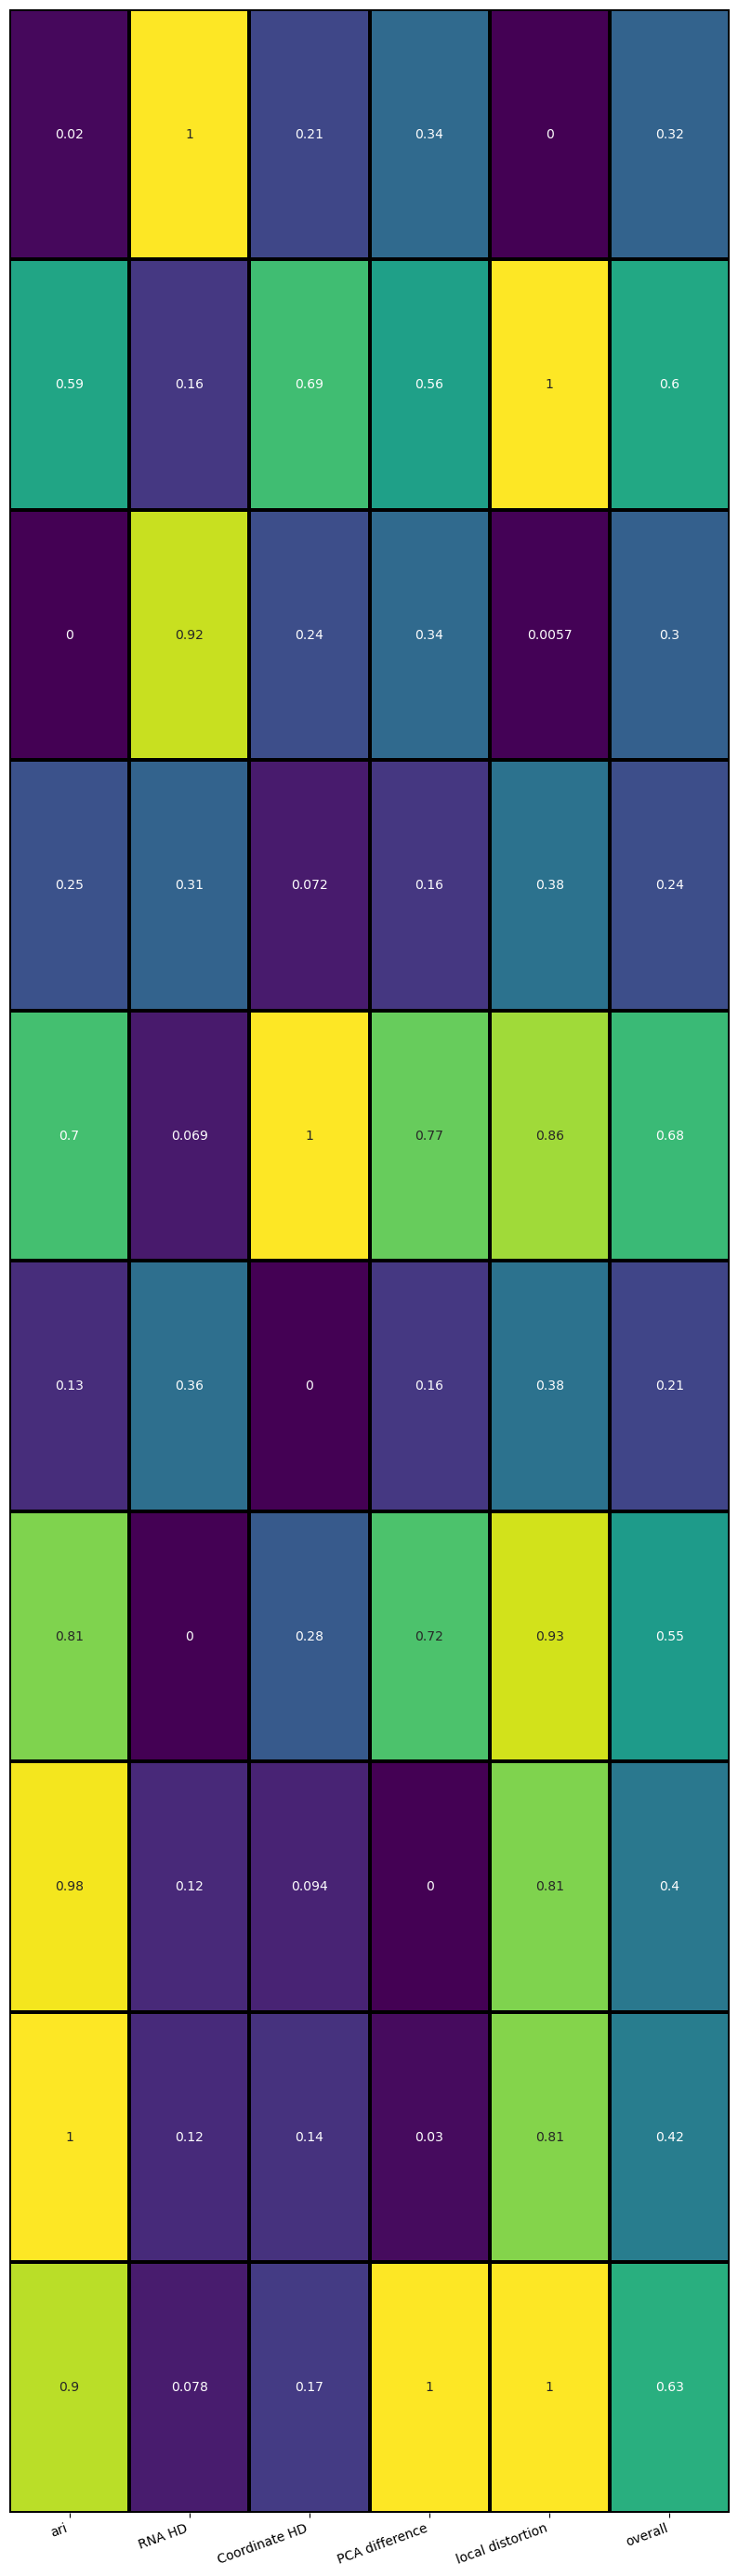

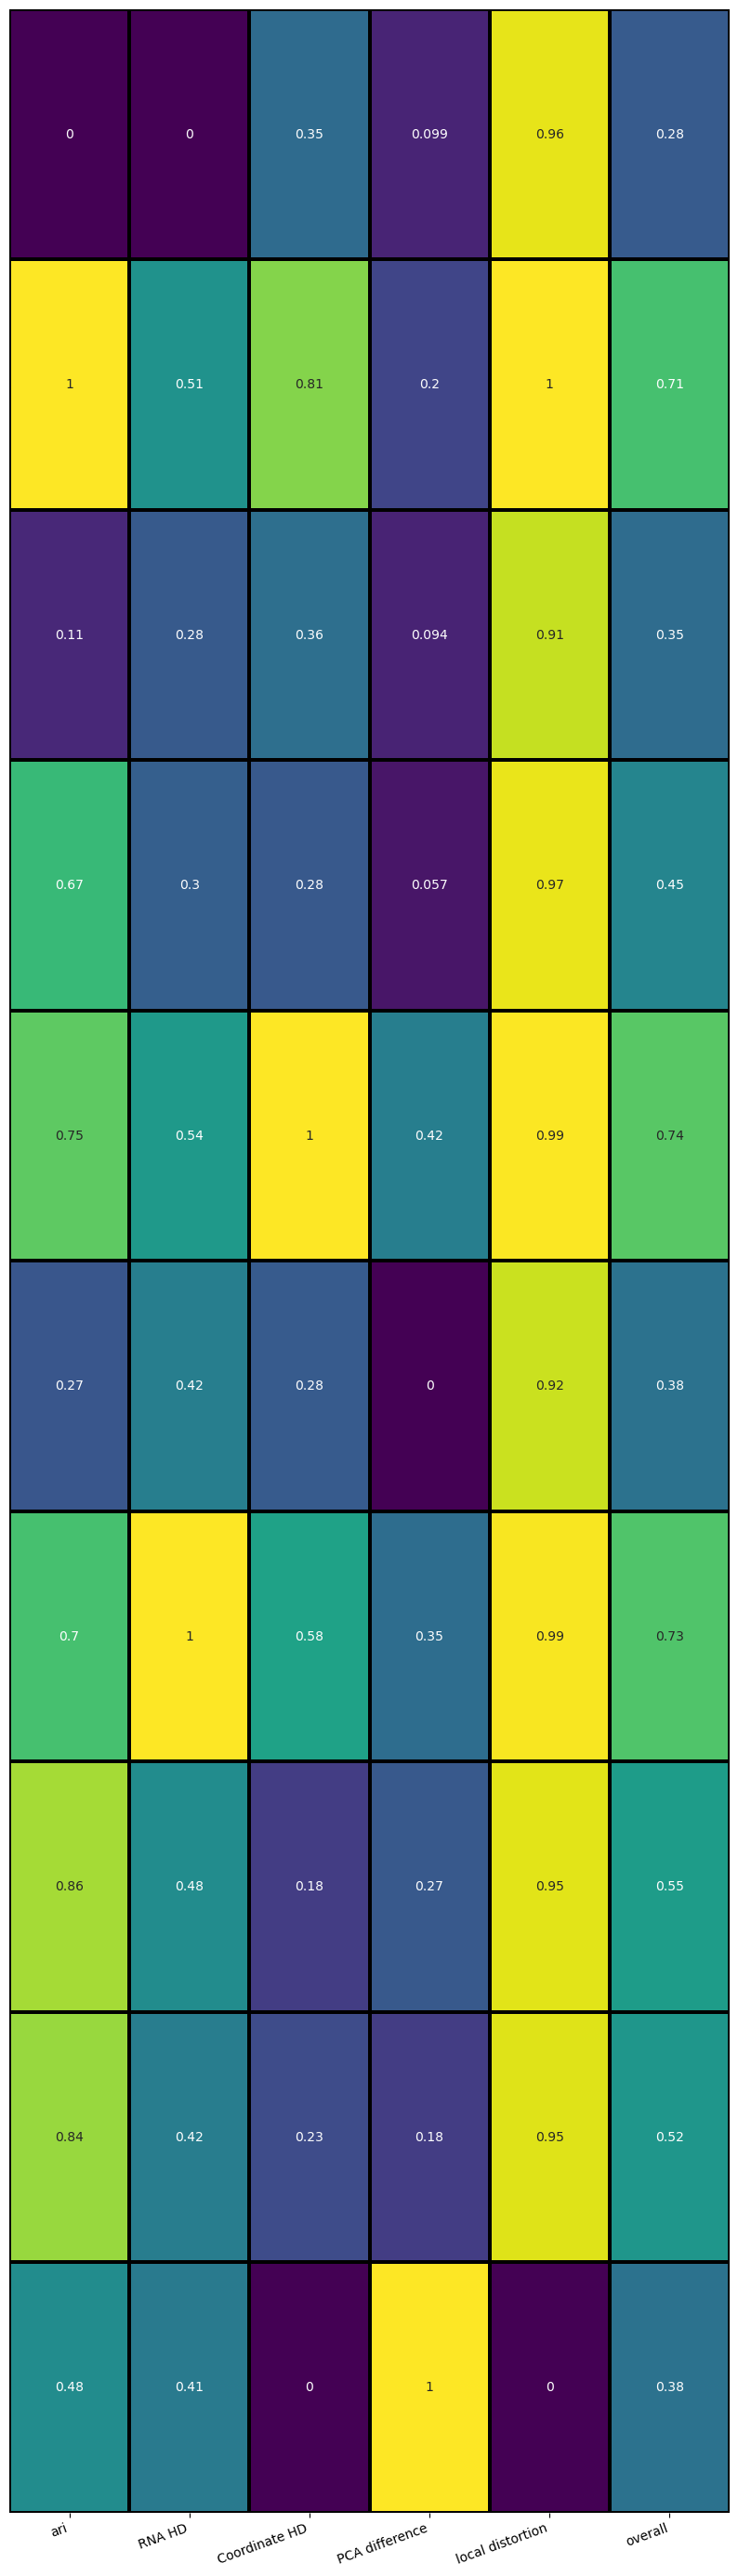

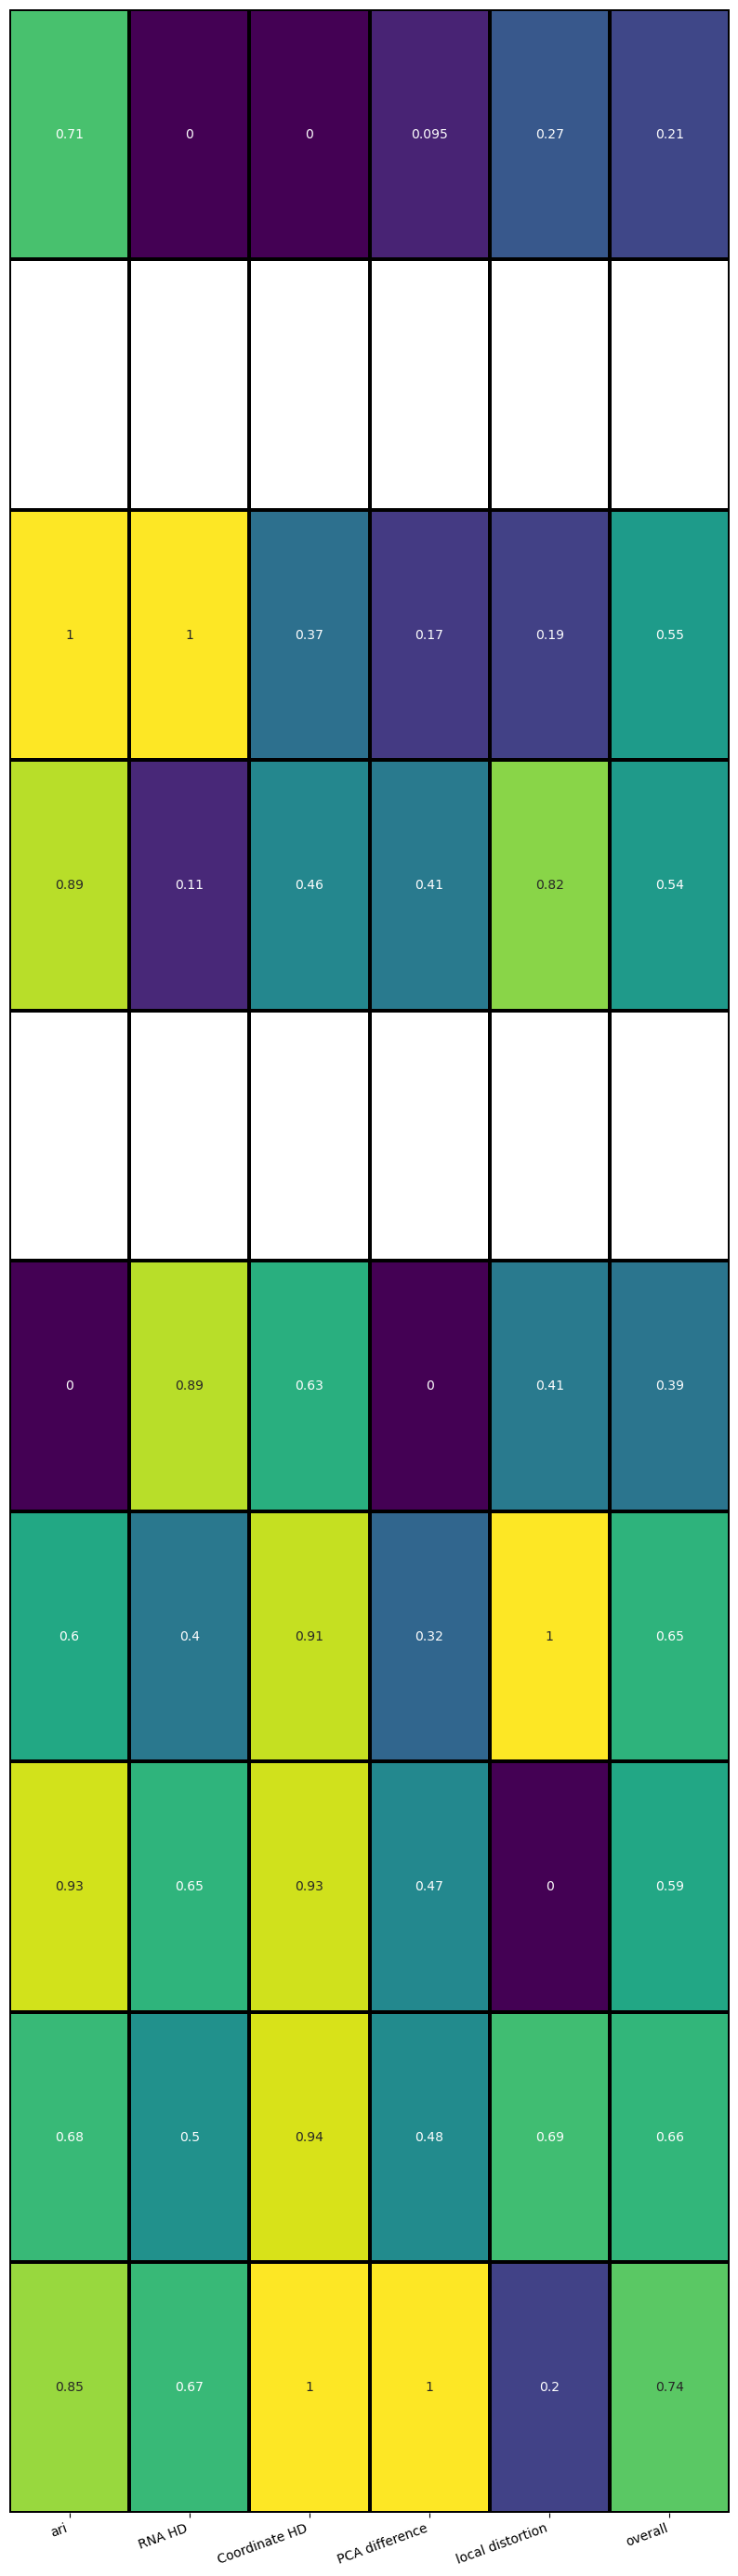

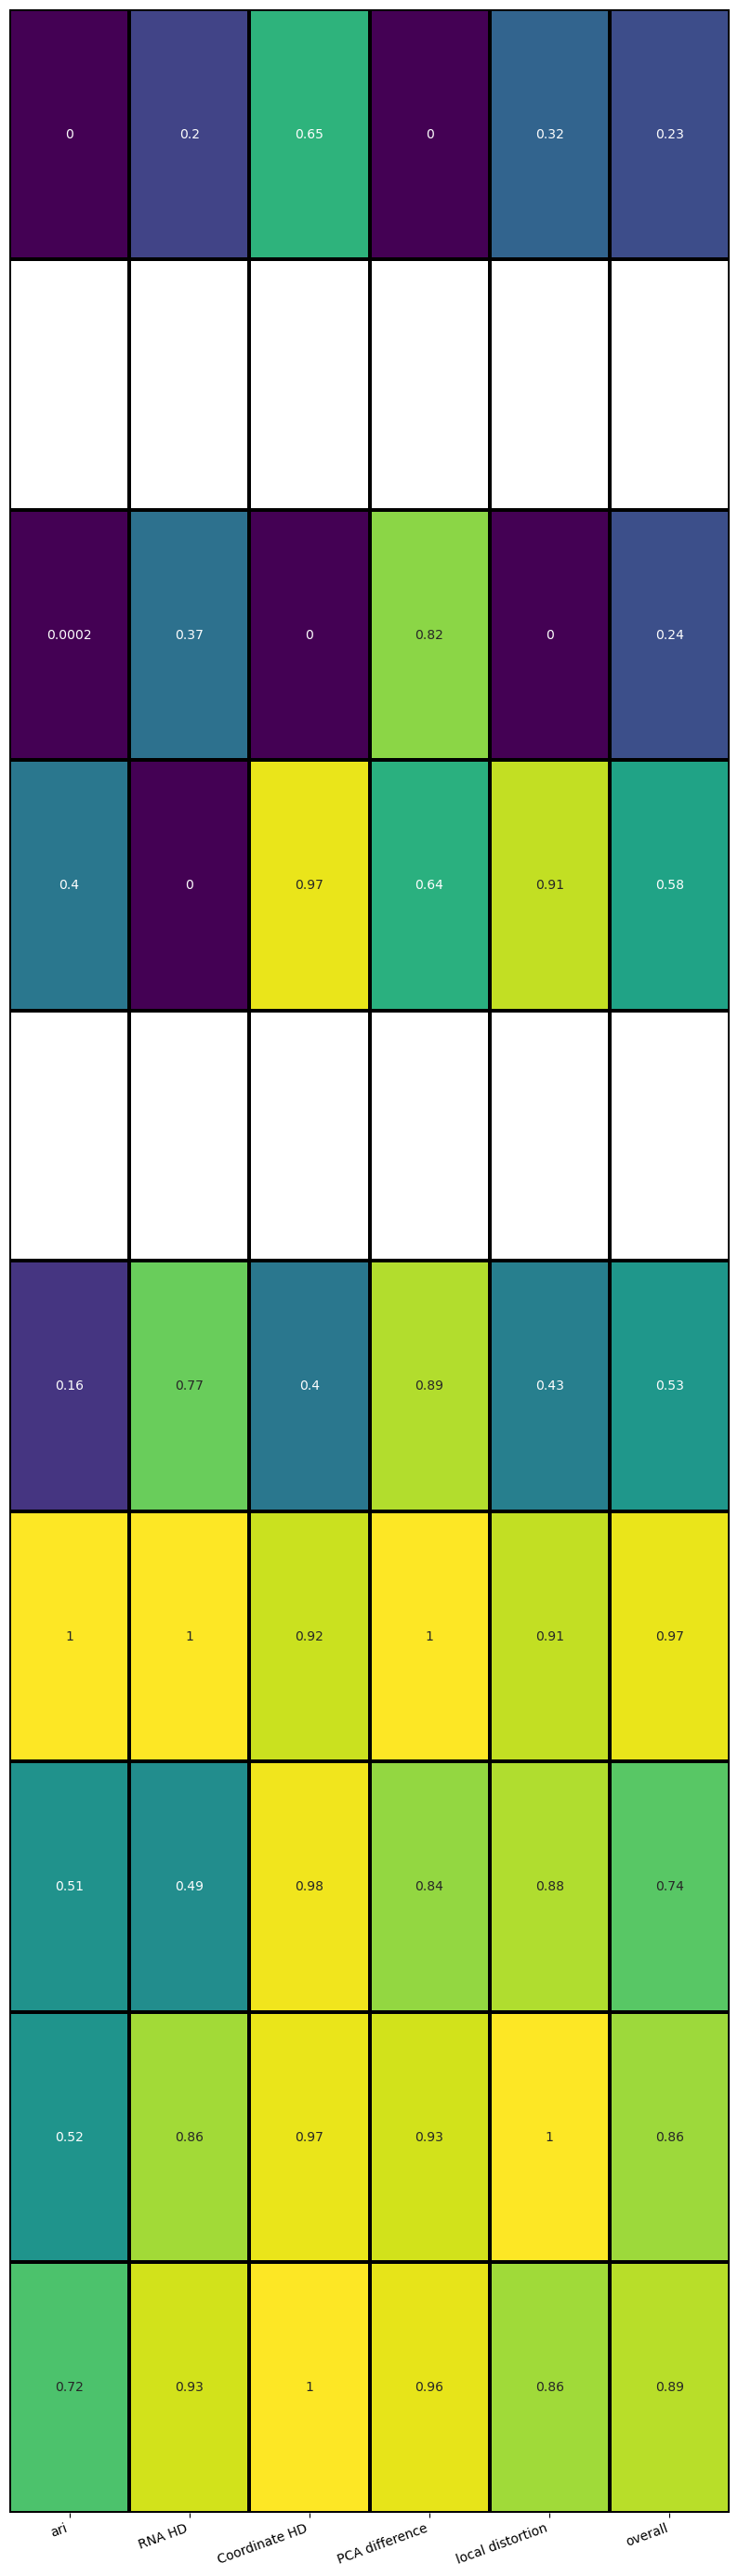

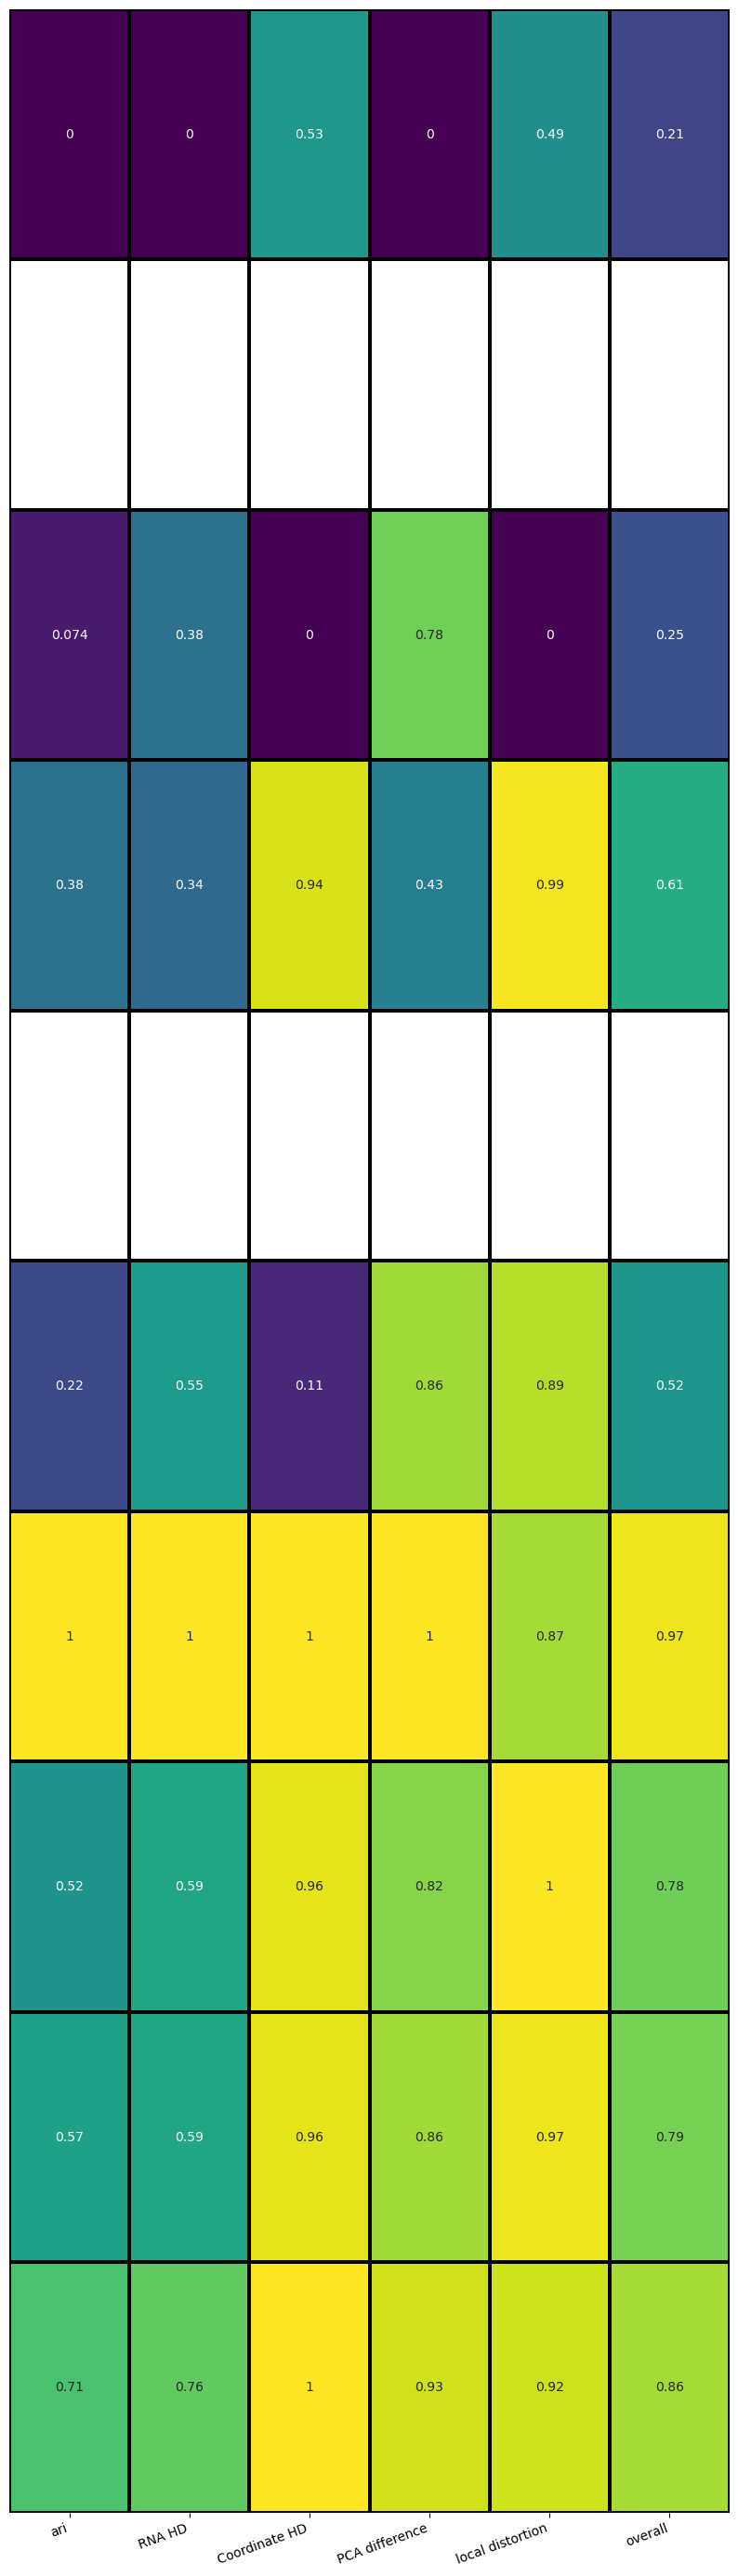

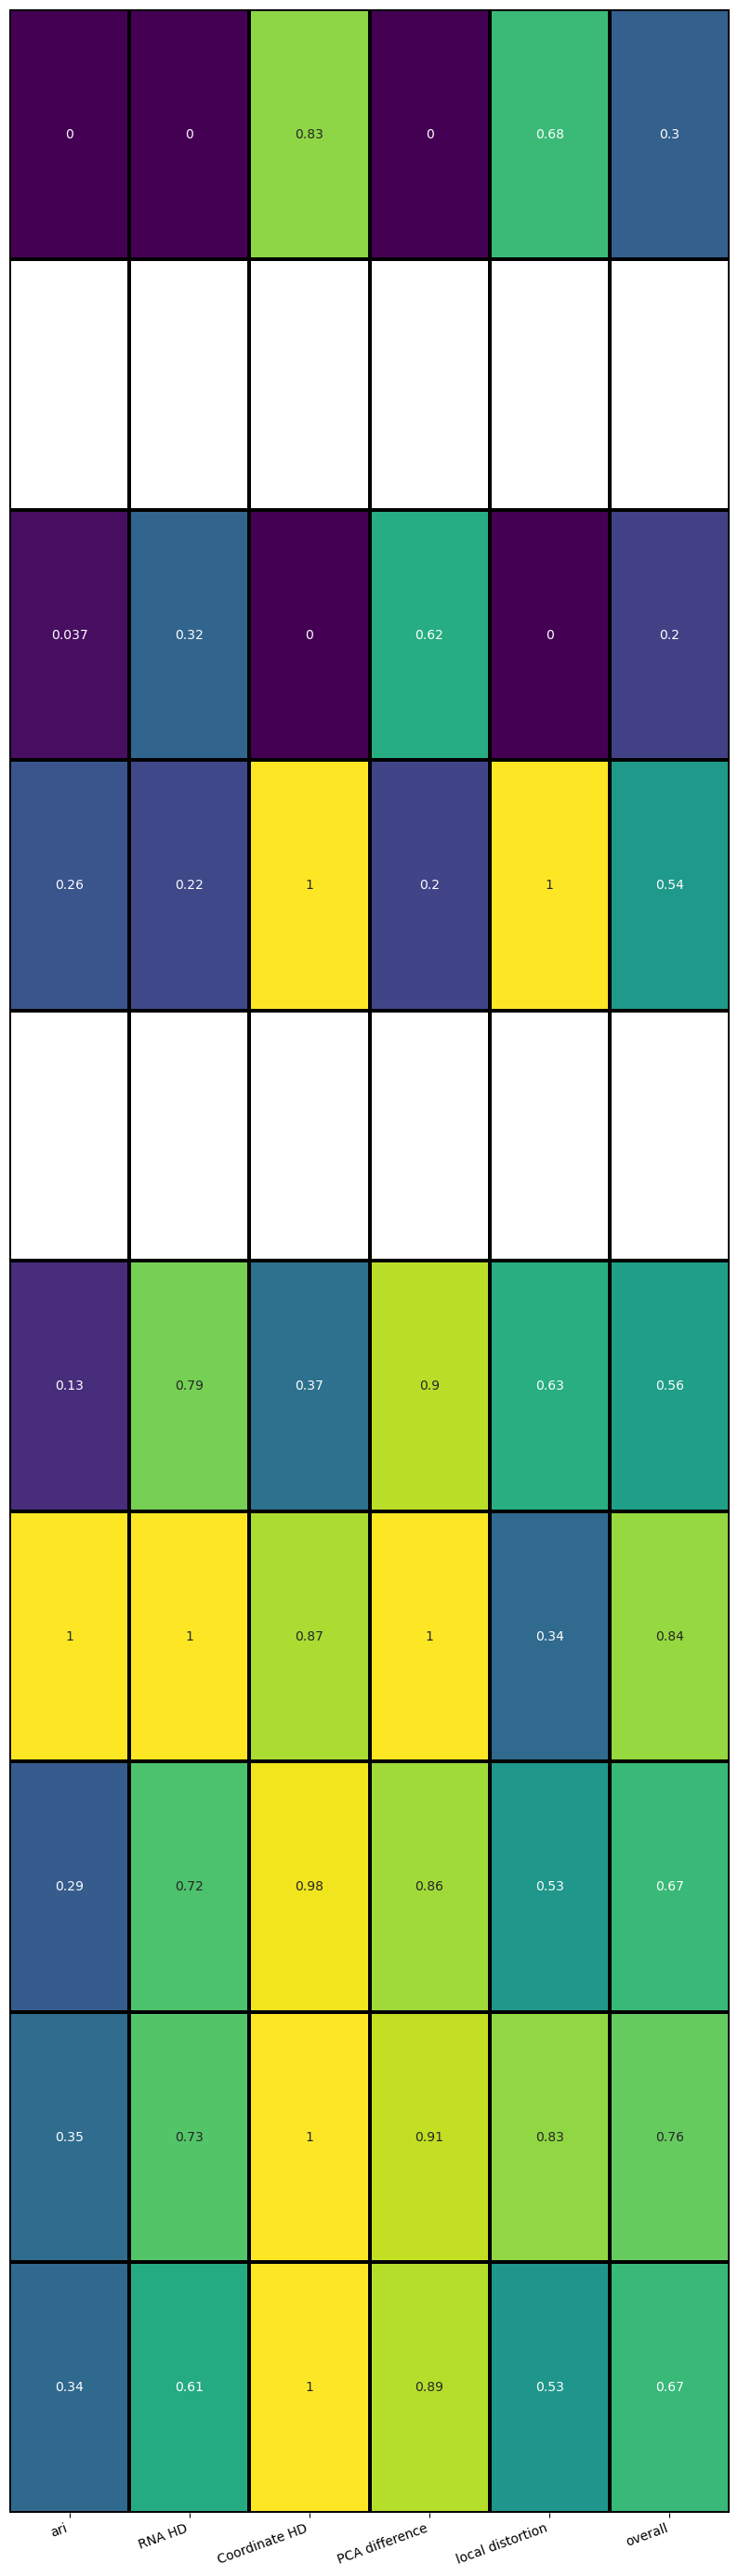

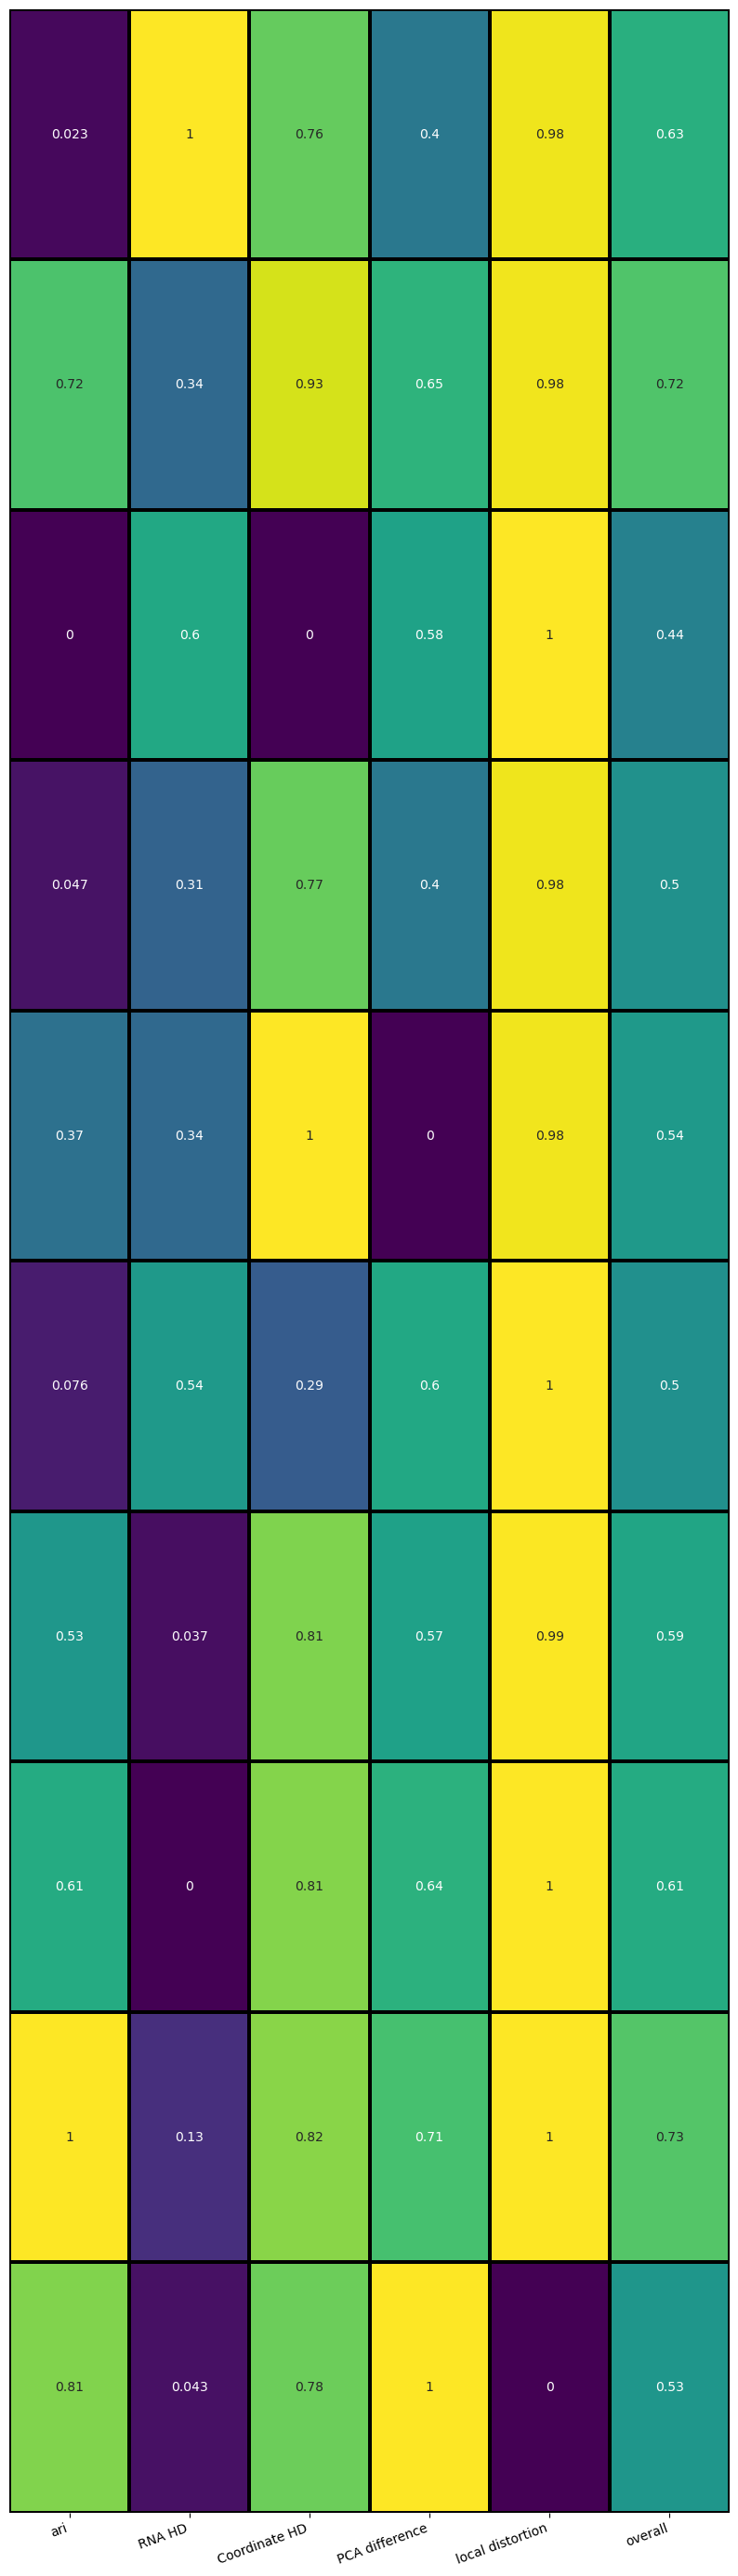

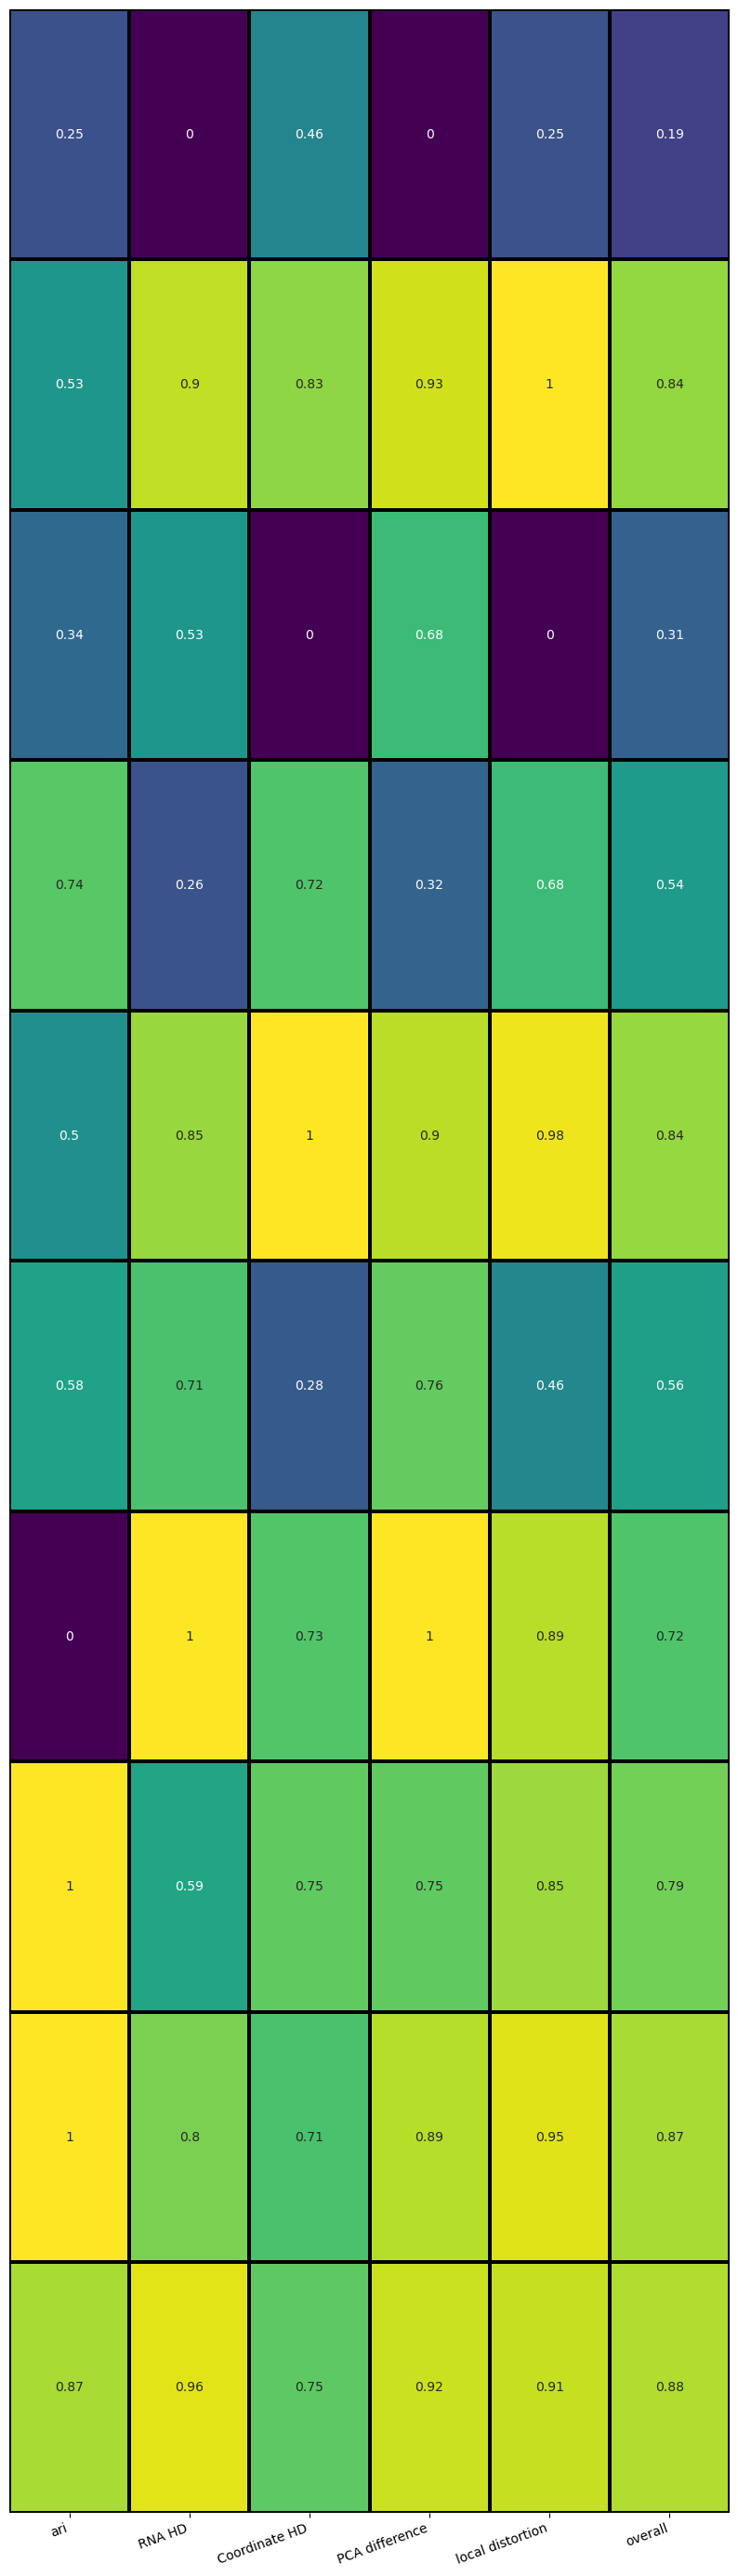

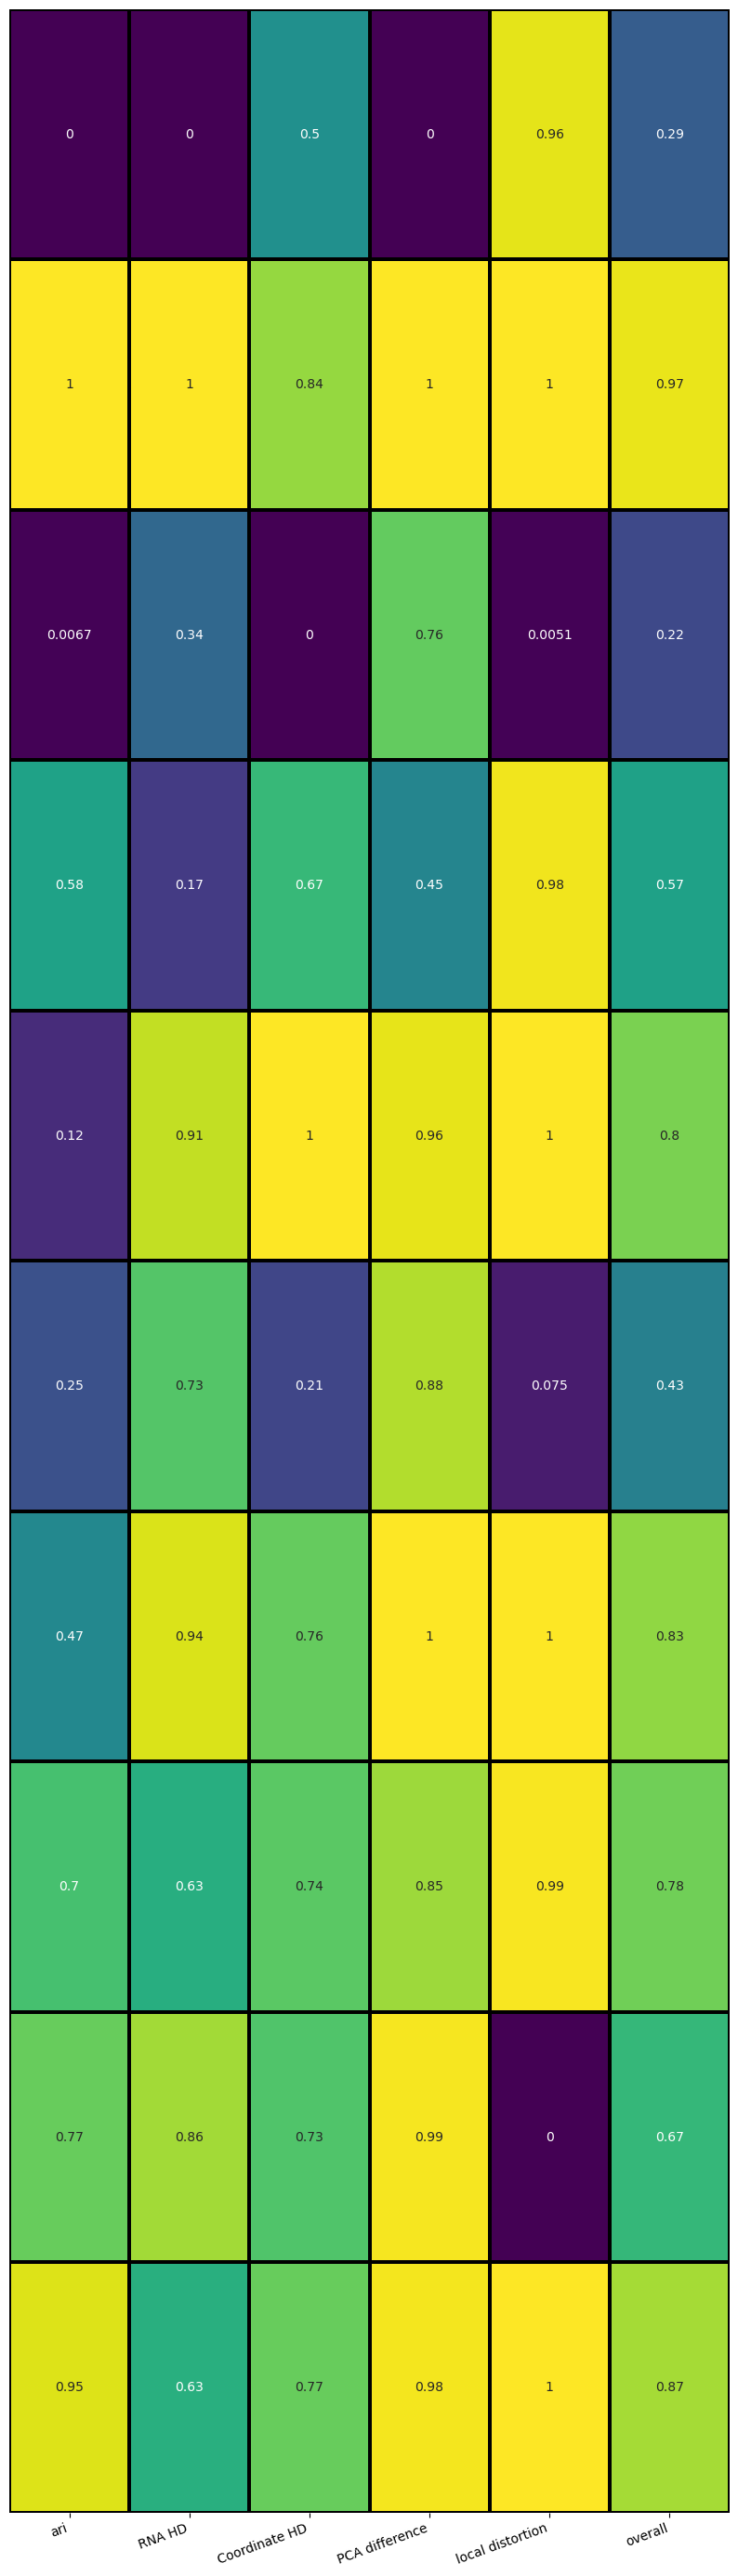

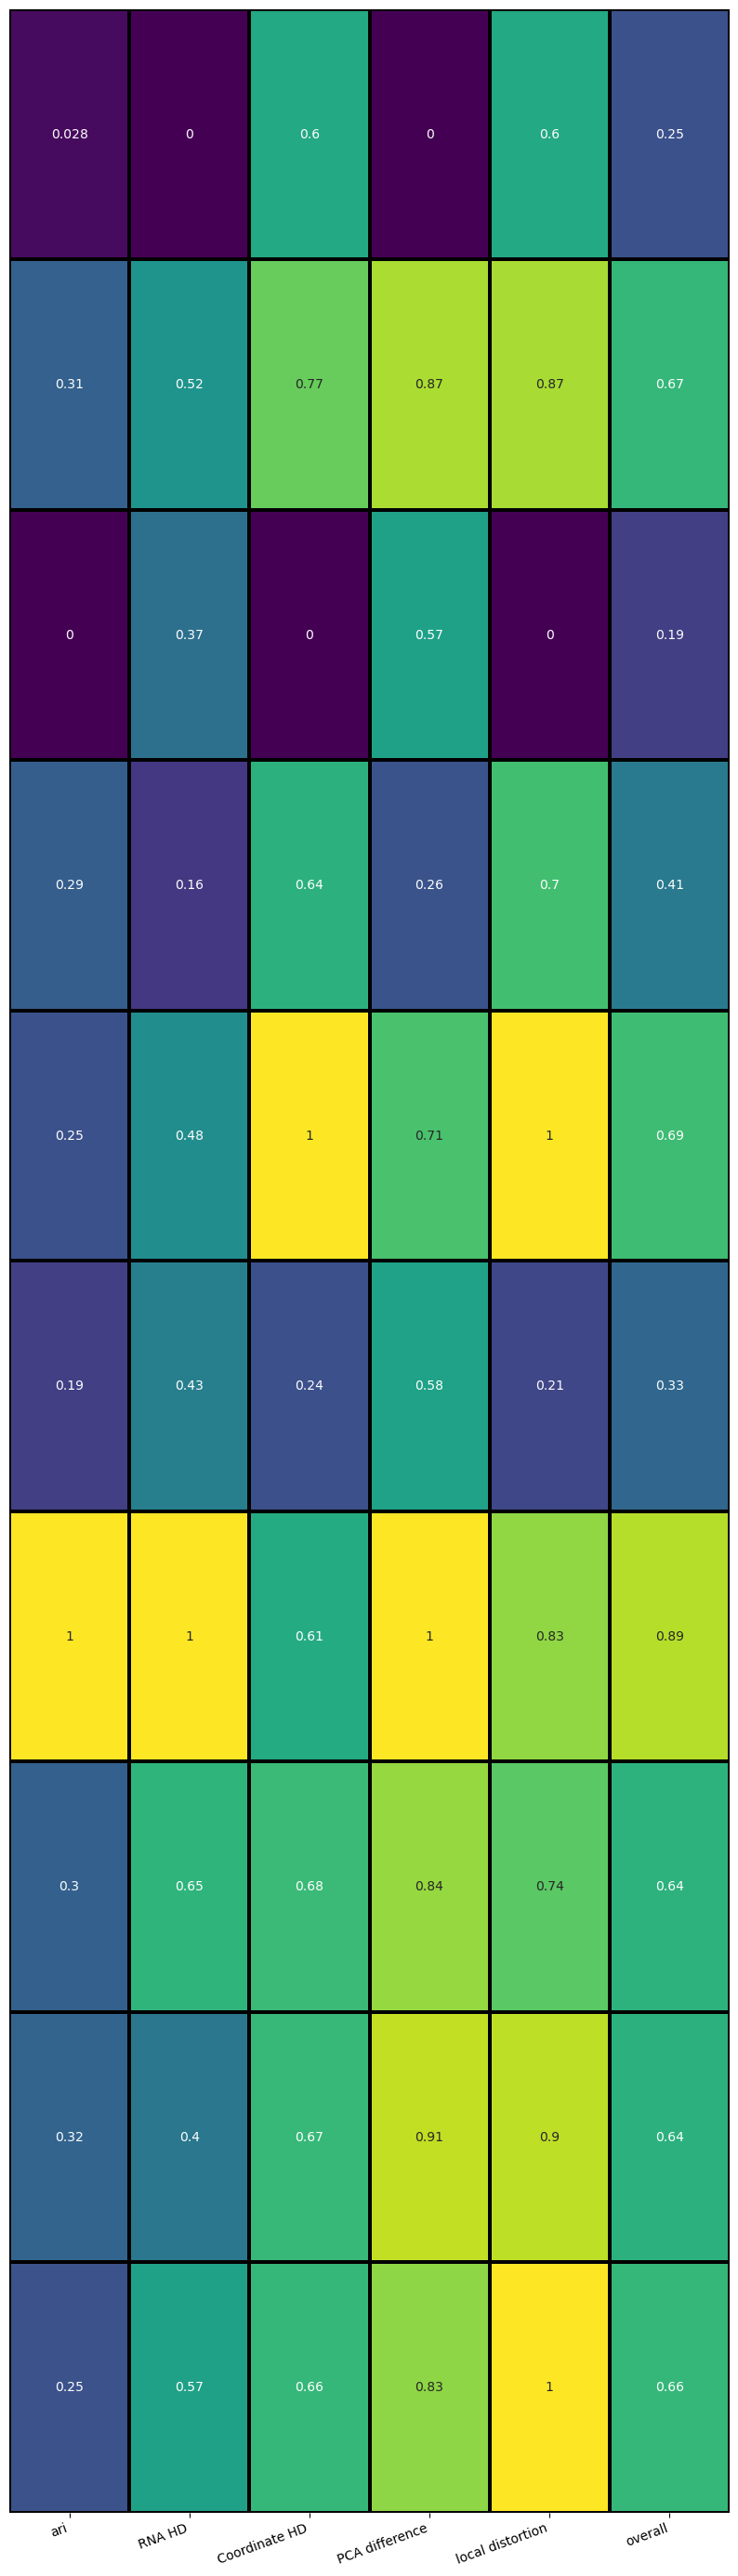

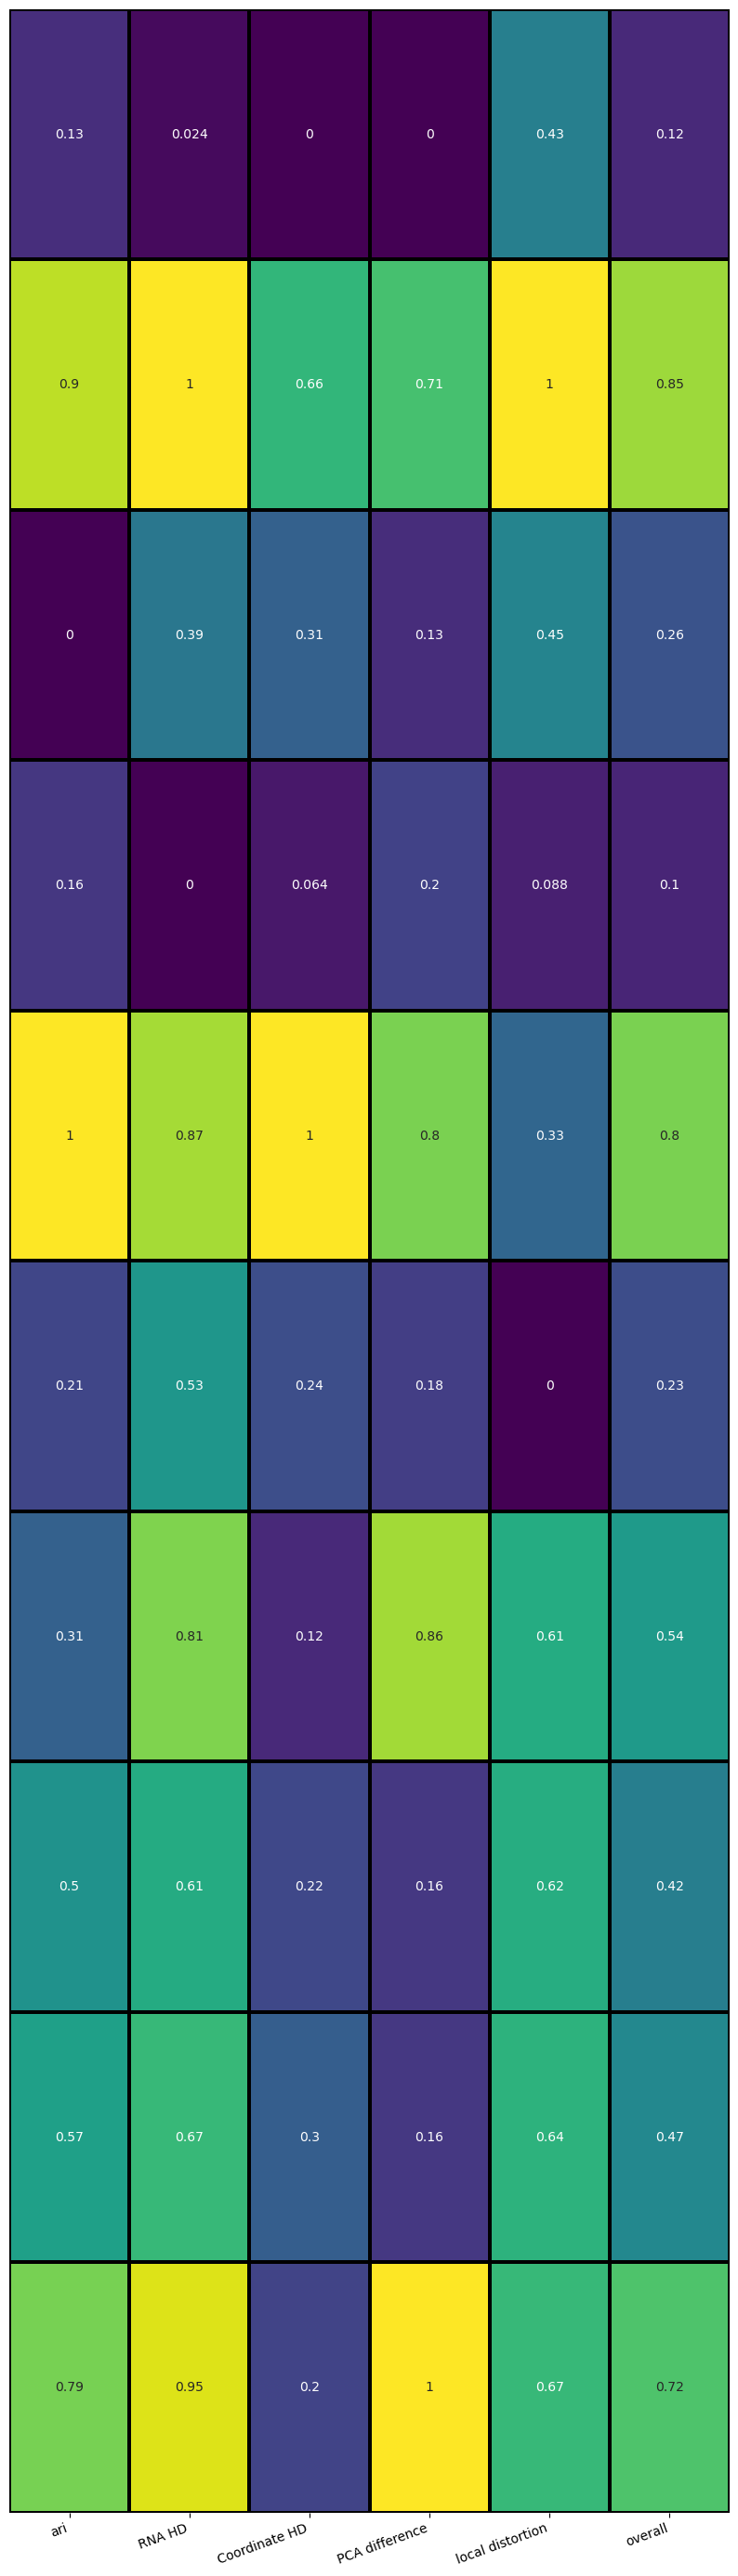

In [124]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)

for dataset in best_methods_norm['dataset'].unique():
#dataset = 'visium_like_complex'

    metrics_norm = [
        'ari_recomputed_pca_norm',              # higher is better
        'transcriptomic_distance_median_norm',  # lower is better
        'coord_distance_median_norm',           # lower is better
        'pca_mean_diff_median_norm',            # lower is better
        'mse_median_norm'                       # lower is better
    ] 
    
    # method_order = [
    #     'scsampler_transcriptomic',
    #     'geo_transcriptomic',
    #     'leverage_pca',
    #     'leverage',
    #     'scsampler_coord',
    #     'geo_coords',
    #     'rasp_scsampler',
    #     'rasp_geo',
    #     'rasp_leverage',
    #     'uniform'
    # ]

    method_order = [
        'scsampler_transcriptomic',
        'scsampler_coord',
        'rasp_scsampler',
        'geo_transcriptomic',
        'geo_coords',
        'rasp_geo',
        'leverage',
        'leverage_pca',
        'rasp_leverage',
        'uniform'
    ]
    x_tick_labels = [
        'ari',
        'RNA HD',
        'Coordinate HD',
        'PCA difference',
        'local distortion',
        'overall'
    ]
    
    
    metrics_to_plot = metrics_norm + ['overall_score']
    sub = norm_df[norm_df['dataset'] == dataset].copy()
    # Set method as categorical for custom order
    sub['method'] = pd.Categorical(sub['method'], categories=method_order, ordered=True)
    # Set index and sort
    sub = sub.set_index('method').loc[method_order]
    sub = sub[metrics_to_plot]
    
    
    plt.figure(figsize = (10,35))
    ax=sns.heatmap(sub, annot=True, cmap="viridis",cbar = False,linewidth = 1.5,linecolor = 'black')
    #plt.title(f"Dataset: {dataset}")
    #plt.xlabel("Metric");
    #plt.ylabel("Method");
    ax.set_xticklabels(x_tick_labels, rotation=20, ha='right');  # optionally rotate for clarity
    ax.set_yticklabels([])
    ax.tick_params(axis='y', left=False)
    
    # Remove y-axis label
    ax.set_ylabel("");
    
    
    plt.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{dataset}_heatmap_ordered_by_algorithm.svg', 
                format='svg', dpi=300)

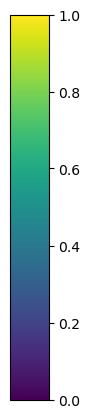

In [98]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
# Create the colorbar separately
norm = mcolors.Normalize(vmin=norm_df['overall_score_scaled'].min(), vmax=norm_df['overall_score_scaled'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for older versions of Matplotlib

# Now plot the colorbar
fig_colorbar, ax_colorbar = plt.subplots(figsize=(.5, 5))  # Adjust size as necessary
cbar = plt.colorbar(sm, cax=ax_colorbar)
cbar.set_label('')  # You can set the label for the colorbar
plt.savefig('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/colormap.svg', 
            dpi=300, bbox_inches='tight',format = 'svg')
plt.show()

In [121]:
dataset = 'visium_HD_brain'
sub = rank_df[rank_df['dataset'] == dataset].copy()
sub[metrics] = sub[metrics].replace(0, np.nan)

,method,ari_recomputed_pca,transcriptomic_distance_median,transcriptomic_distance_5%,transcriptomic_distance_95%,coord_distance_median,coord_distance_5%,coord_distance_95%,pca_mean_diff_median,pca_mean_diff_5%,...,mse_5%,mse_95%,dataset,fraction,ari_recomputed_pca_rank,transcriptomic_distance_median_rank,coord_distance_median_rank,pca_mean_diff_median_rank,mse_median_rank,rank_sum
20,geo_transcriptomic,0.234957,8.289064,8.271123,8.316568,683.781616,421.340913,860.967389,2.544294,2.495166,...,0.008277,0.008397,visium_HD_brain,0.1,3.0,7.0,6.0,4.0,2.0,22.0
21,leverage,0.165261,8.267701,8.243234,8.287680,249.392036,243.844701,272.539694,2.790462,2.112686,...,0.007028,0.007146,visium_HD_brain,0.1,7.0,6.0,4.0,5.0,1.0,23.0
22,scsampler_transcriptomic,0.191049,8.297441,8.273463,8.320872,1132.227356,767.774985,1256.324695,3.472366,3.227804,...,0.012071,0.012231,visium_HD_brain,0.1,5.0,8.0,8.0,7.0,5.0,33.0
23,uniform,0.223760,8.247287,8.211177,8.271394,165.149643,157.244976,170.254691,0.788161,0.326939,...,0.012563,0.012796,visium_HD_brain,0.1,4.0,3.0,1.0,1.0,6.0,15.0
24,rasp_geo,0.022885,8.230747,8.216765,8.270381,521.055695,501.188557,669.833411,3.752505,3.730856,...,0.011184,0.011312,visium_HD_brain,0.1,8.0,2.0,5.0,8.0,4.0,27.0
25,rasp_scsampler,0.260601,8.222881,8.209991,8.243766,778.037140,740.941525,907.632761,3.246969,3.164931,...,0.012605,0.012804,visium_HD_brain,0.1,1.0,1.0,7.0,6.0,7.0,22.0
26,rasp_leverage,0.183362,8.260091,8.241515,8.295035,222.323502,211.414004,235.442164,2.338294,2.063180,...,0.009189,0.009352,visium_HD_brain,0.1,6.0,5.0,2.0,2.0,3.0,18.0
27,leverage_pca,0.244108,8.249045,8.216684,8.280816,234.484848,227.980798,263.717009,2.373899,2.290843,...,0.013949,0.014134,visium_HD_brain,0.1,2.0,4.0,3.0,3.0,8.0,20.0
28,geo_coords,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,visium_HD_brain,0.1,NaN,NaN,NaN,NaN,NaN,0.0
29,scsampler_coord,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,visium_HD_brain,0.1,NaN,NaN,NaN,NaN,NaN,0.0


In [9]:
rank_df

,method,ari_recomputed_pca,transcriptomic_distance_median,transcriptomic_distance_5%,transcriptomic_distance_95%,coord_distance_median,coord_distance_5%,coord_distance_95%,pca_mean_diff_median,pca_mean_diff_5%,...,mse_5%,mse_95%,dataset,fraction,ari_recomputed_pca_rank,transcriptomic_distance_median_rank,coord_distance_median_rank,pca_mean_diff_median_rank,mse_median_rank,overall_spatial_rank
0,rasp_geo,0.625529,12.763828,12.682838,12.905536,0.208678,0.193842,0.255151,8.807002,8.751383,...,0.006156,0.006334,allen_merfish_brain,0.1,8.0,3.0,10.0,7.0,7.0,25.0
1,rasp_scsampler,0.595452,12.459712,12.304991,12.553196,0.185167,0.174278,0.194407,7.885367,7.515398,...,0.007063,0.007278,allen_merfish_brain,0.1,10.0,2.0,4.0,5.0,9.0,23.0
2,rasp_leverage,0.835317,12.898687,12.791933,12.997734,0.194712,0.185505,0.210323,9.474865,8.591629,...,0.005003,0.005295,allen_merfish_brain,0.1,1.0,6.0,7.0,9.0,5.0,13.0
3,leverage_pca,0.831450,12.898956,12.849196,13.006442,0.199373,0.186304,0.206507,9.625182,9.245345,...,0.005061,0.005241,allen_merfish_brain,0.1,2.0,7.0,8.0,10.0,6.0,16.0
4,geo_coords,0.763349,12.925204,12.824427,12.979510,0.110002,0.104947,0.113690,5.736105,5.366111,...,0.005011,0.005156,allen_merfish_brain,0.1,5.0,9.0,1.0,2.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,uniform,0.109934,15.539207,15.526062,15.550176,0.032780,0.031036,0.035264,4.071014,3.933854,...,0.002705,0.003050,xenium_like_stripes,0.1,6.0,3.0,5.0,5.0,1.0,12.0
106,rasp_geo,0.097374,15.544992,15.532305,15.560776,0.047133,0.044731,0.051153,4.338673,4.012293,...,0.003091,0.003366,xenium_like_stripes,0.1,8.0,6.0,9.0,7.0,9.0,26.0
107,rasp_scsampler,0.061896,15.547555,15.519084,15.565965,0.055514,0.051824,0.060126,4.344074,4.102007,...,0.003309,0.003710,xenium_like_stripes,0.1,10.0,8.0,10.0,8.0,10.0,30.0
108,rasp_leverage,0.122403,15.546234,15.533808,15.557259,0.032643,0.030666,0.035990,3.991341,3.934300,...,0.002773,0.003149,xenium_like_stripes,0.1,2.0,7.0,4.0,2.0,3.0,9.0


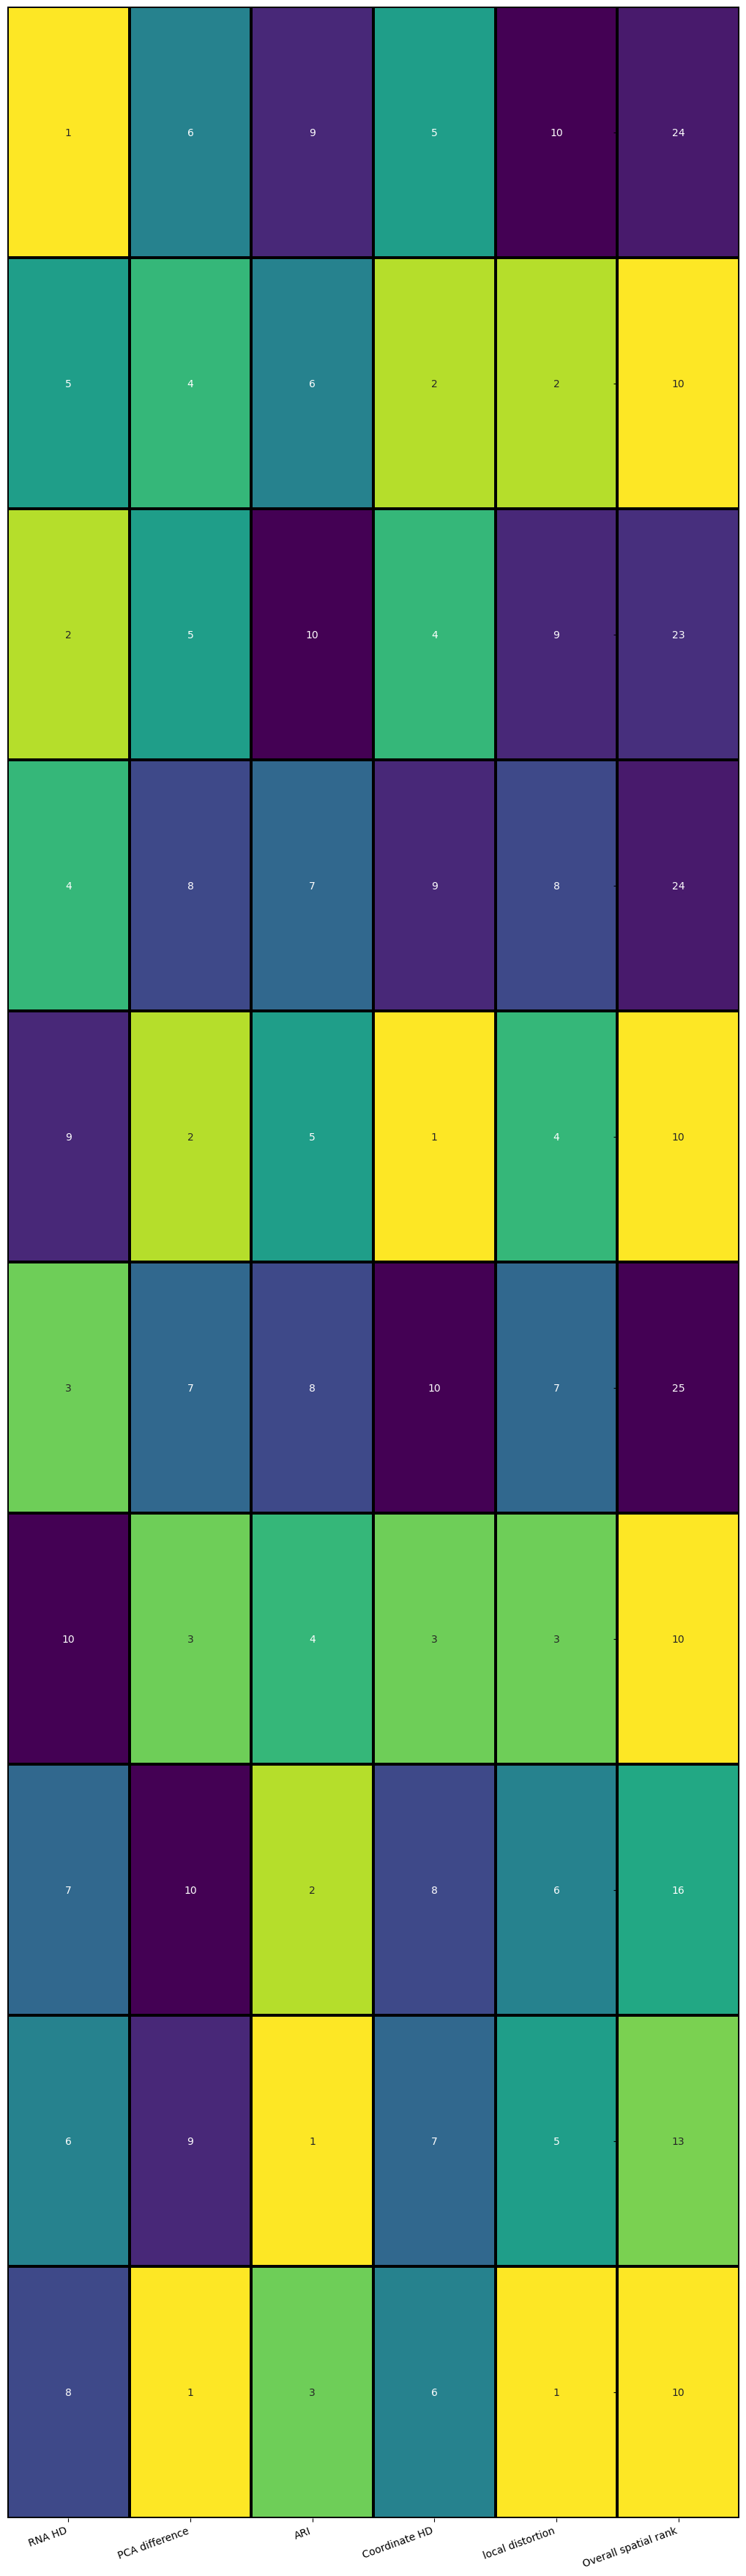

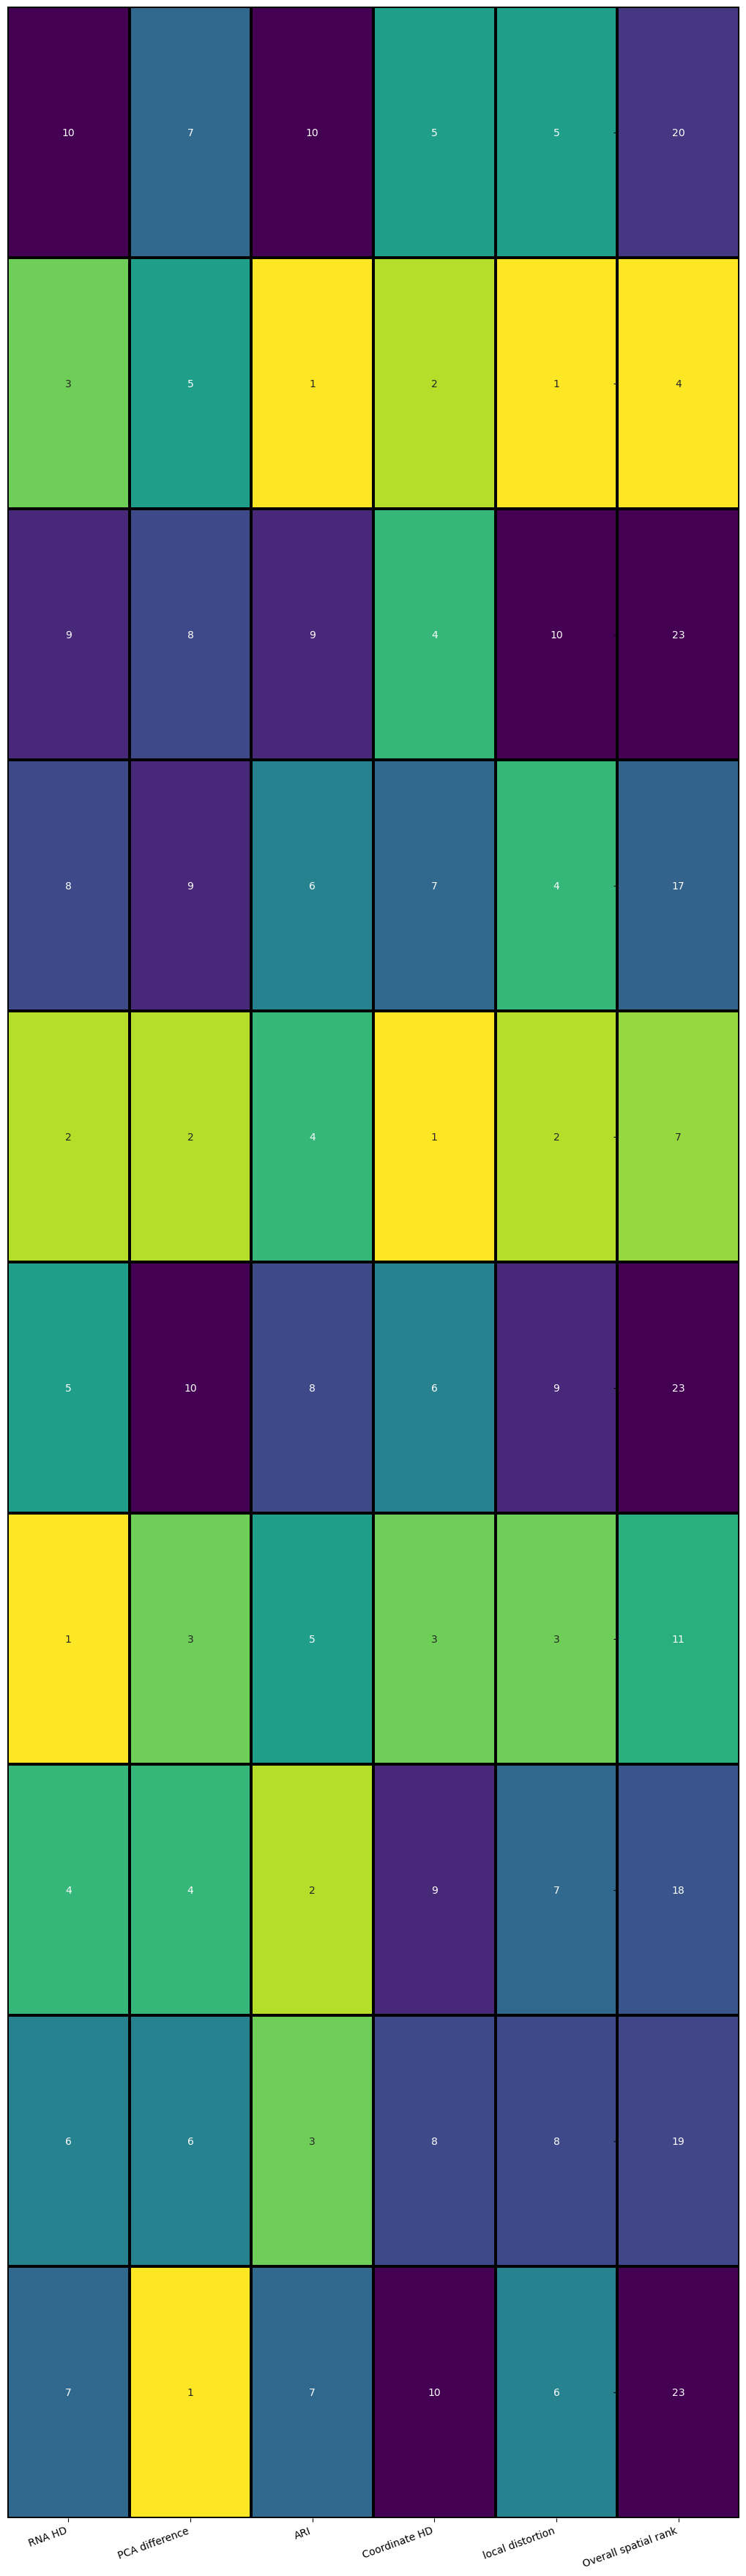

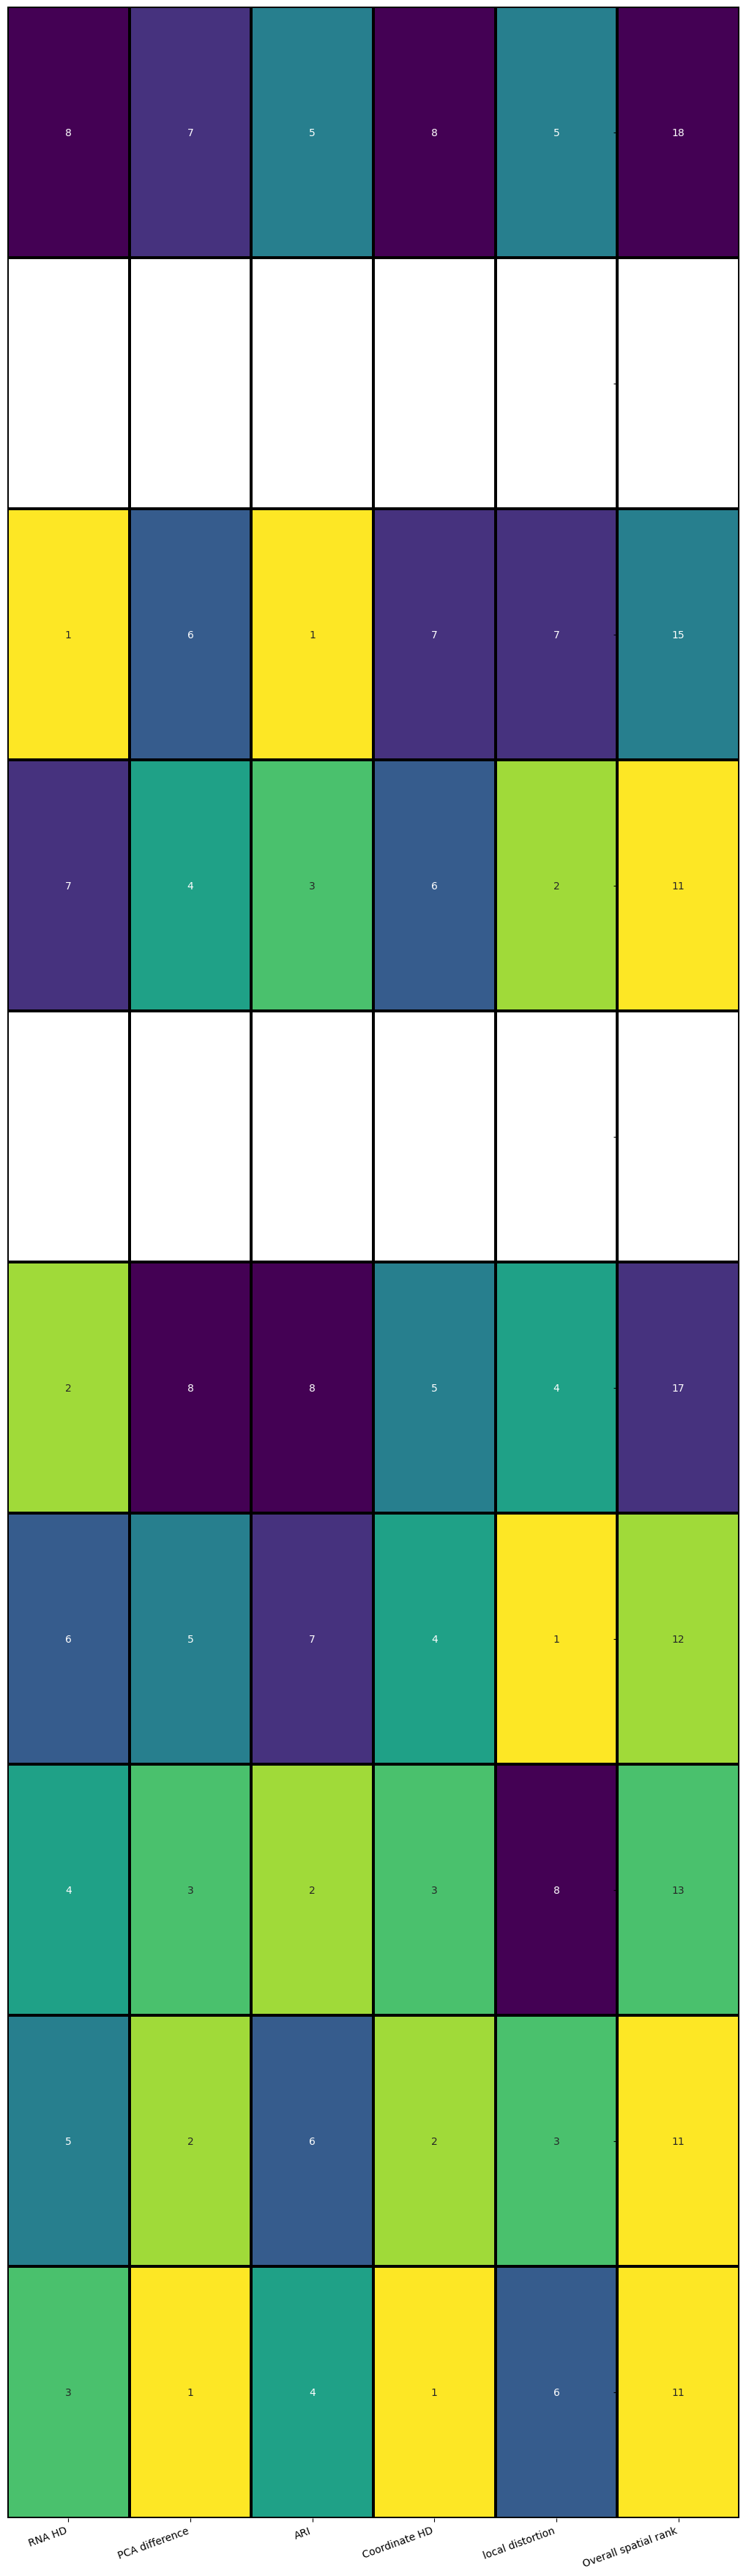

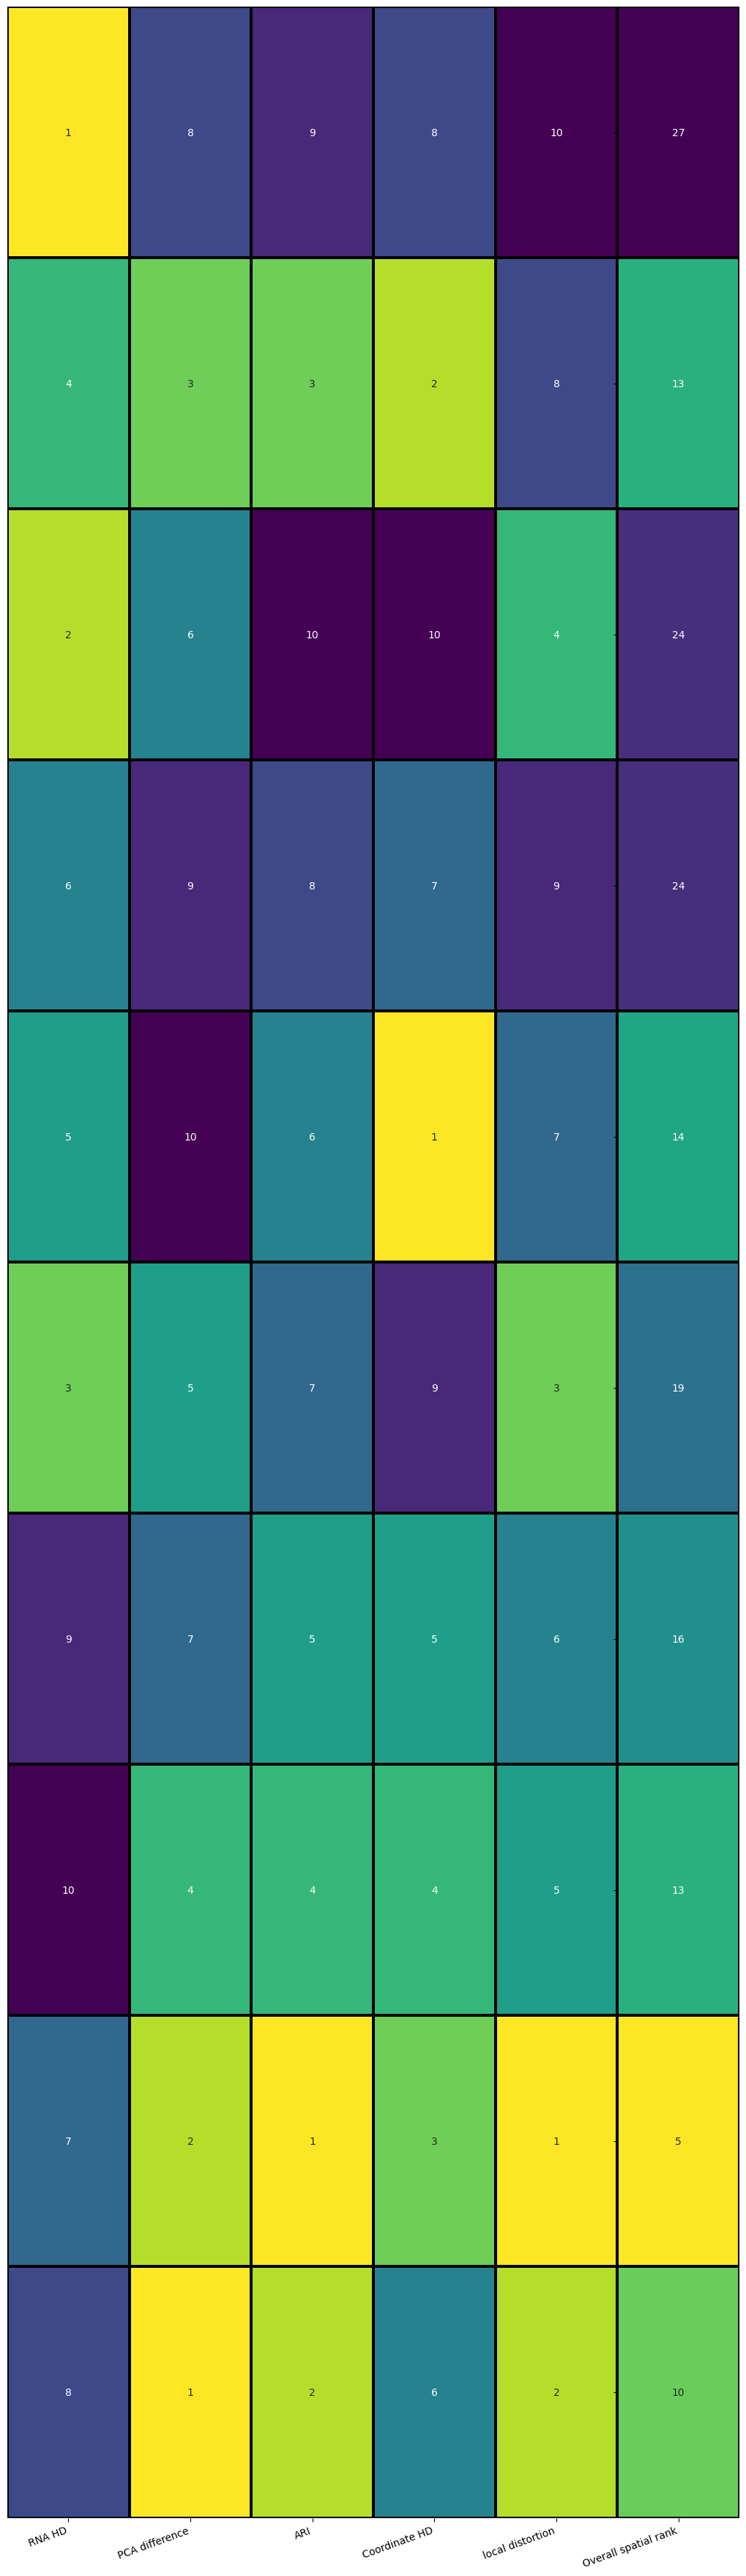

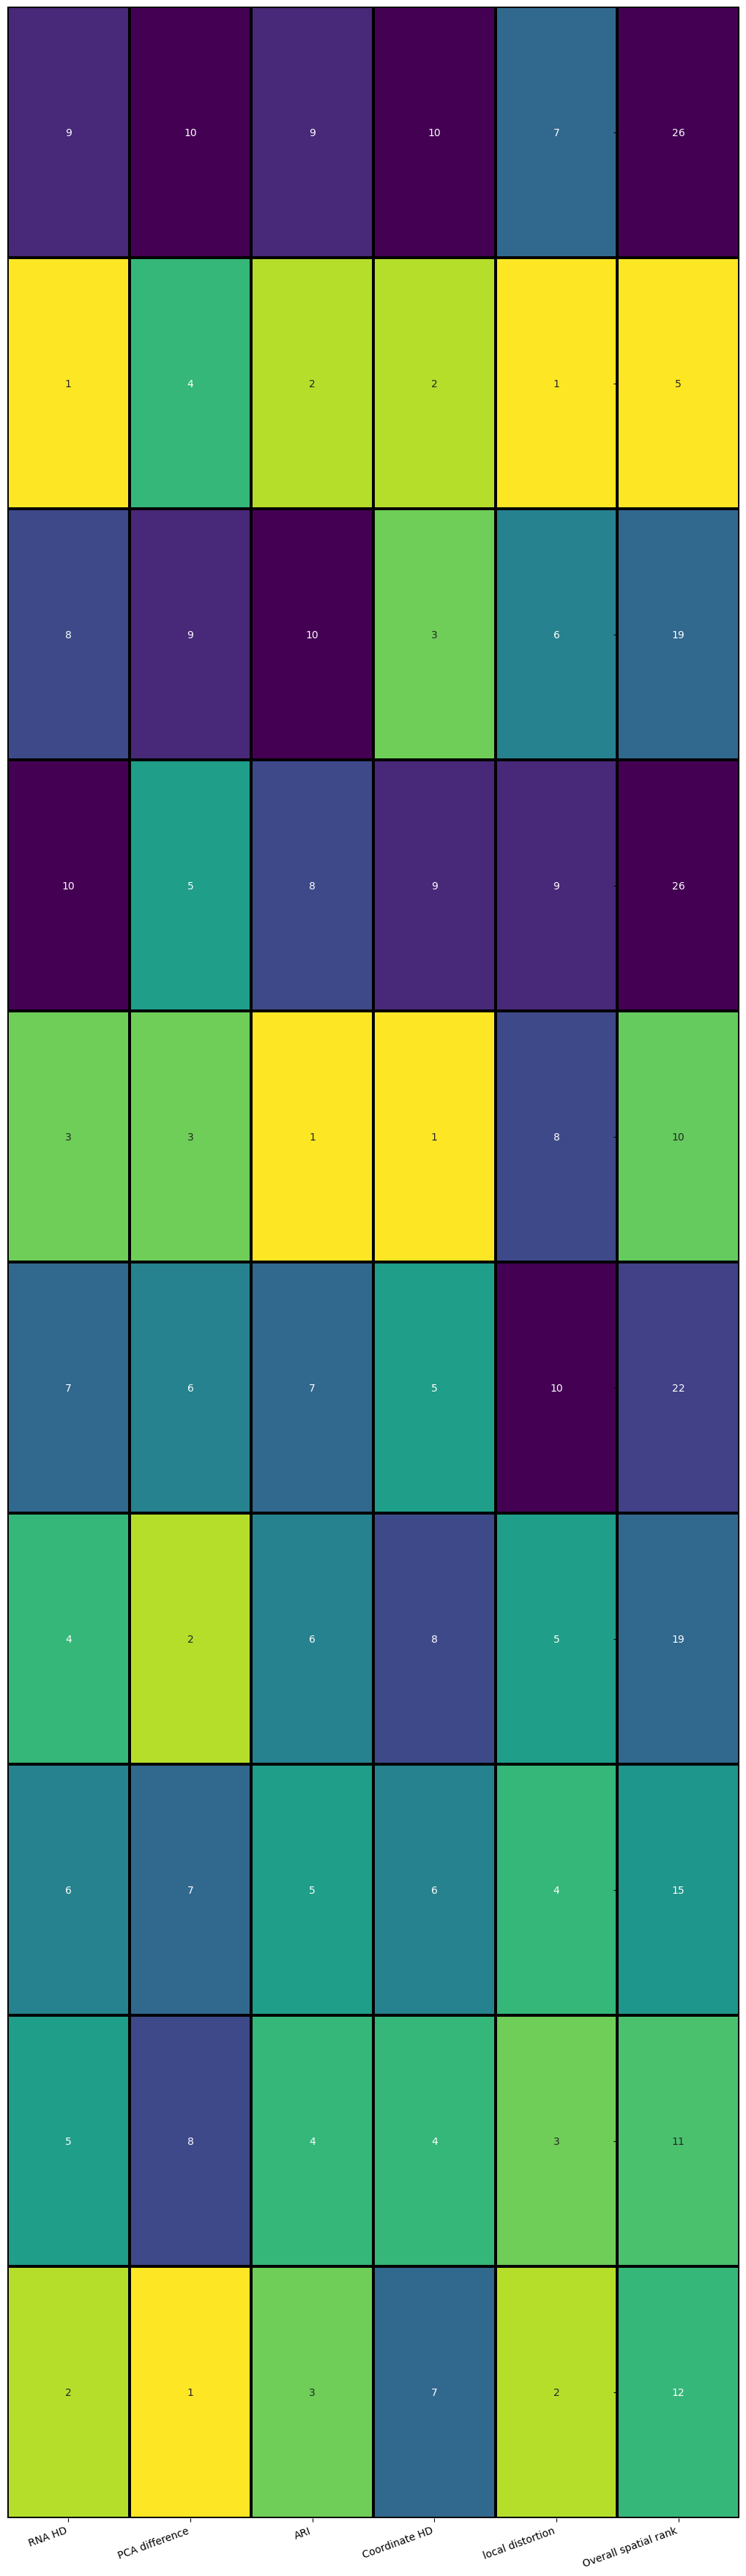

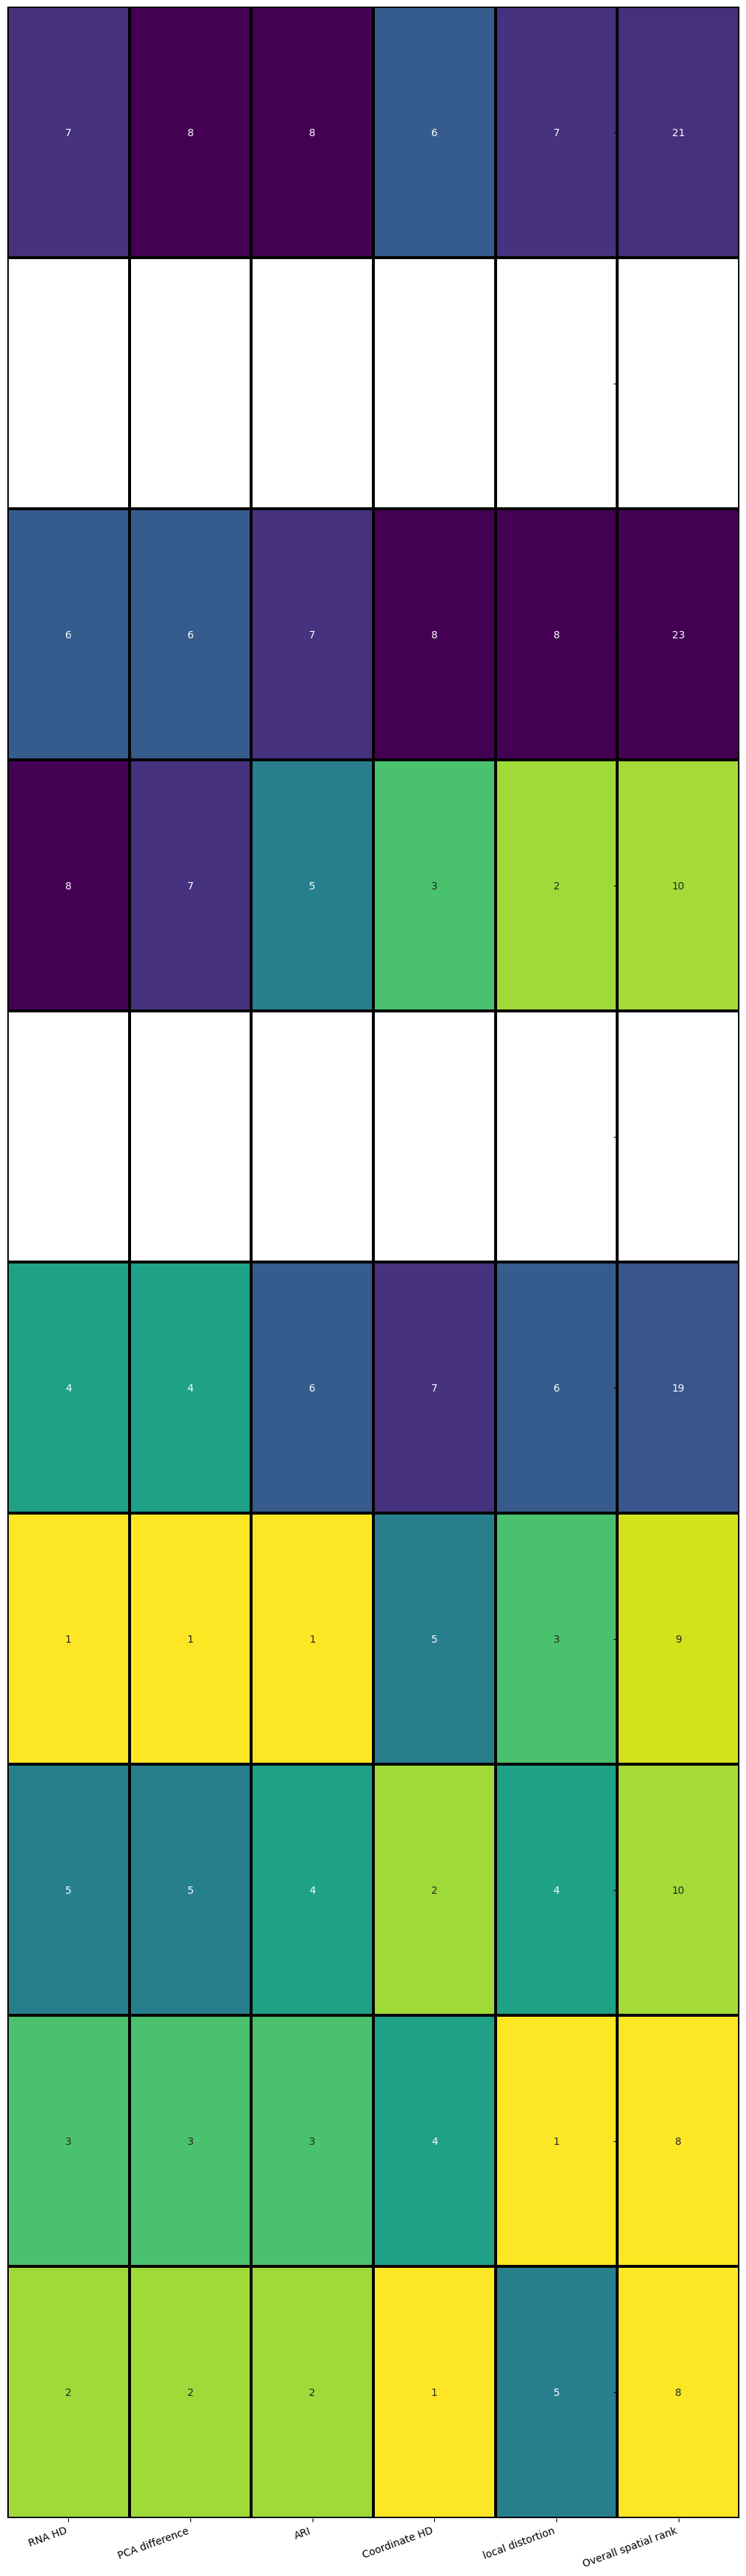

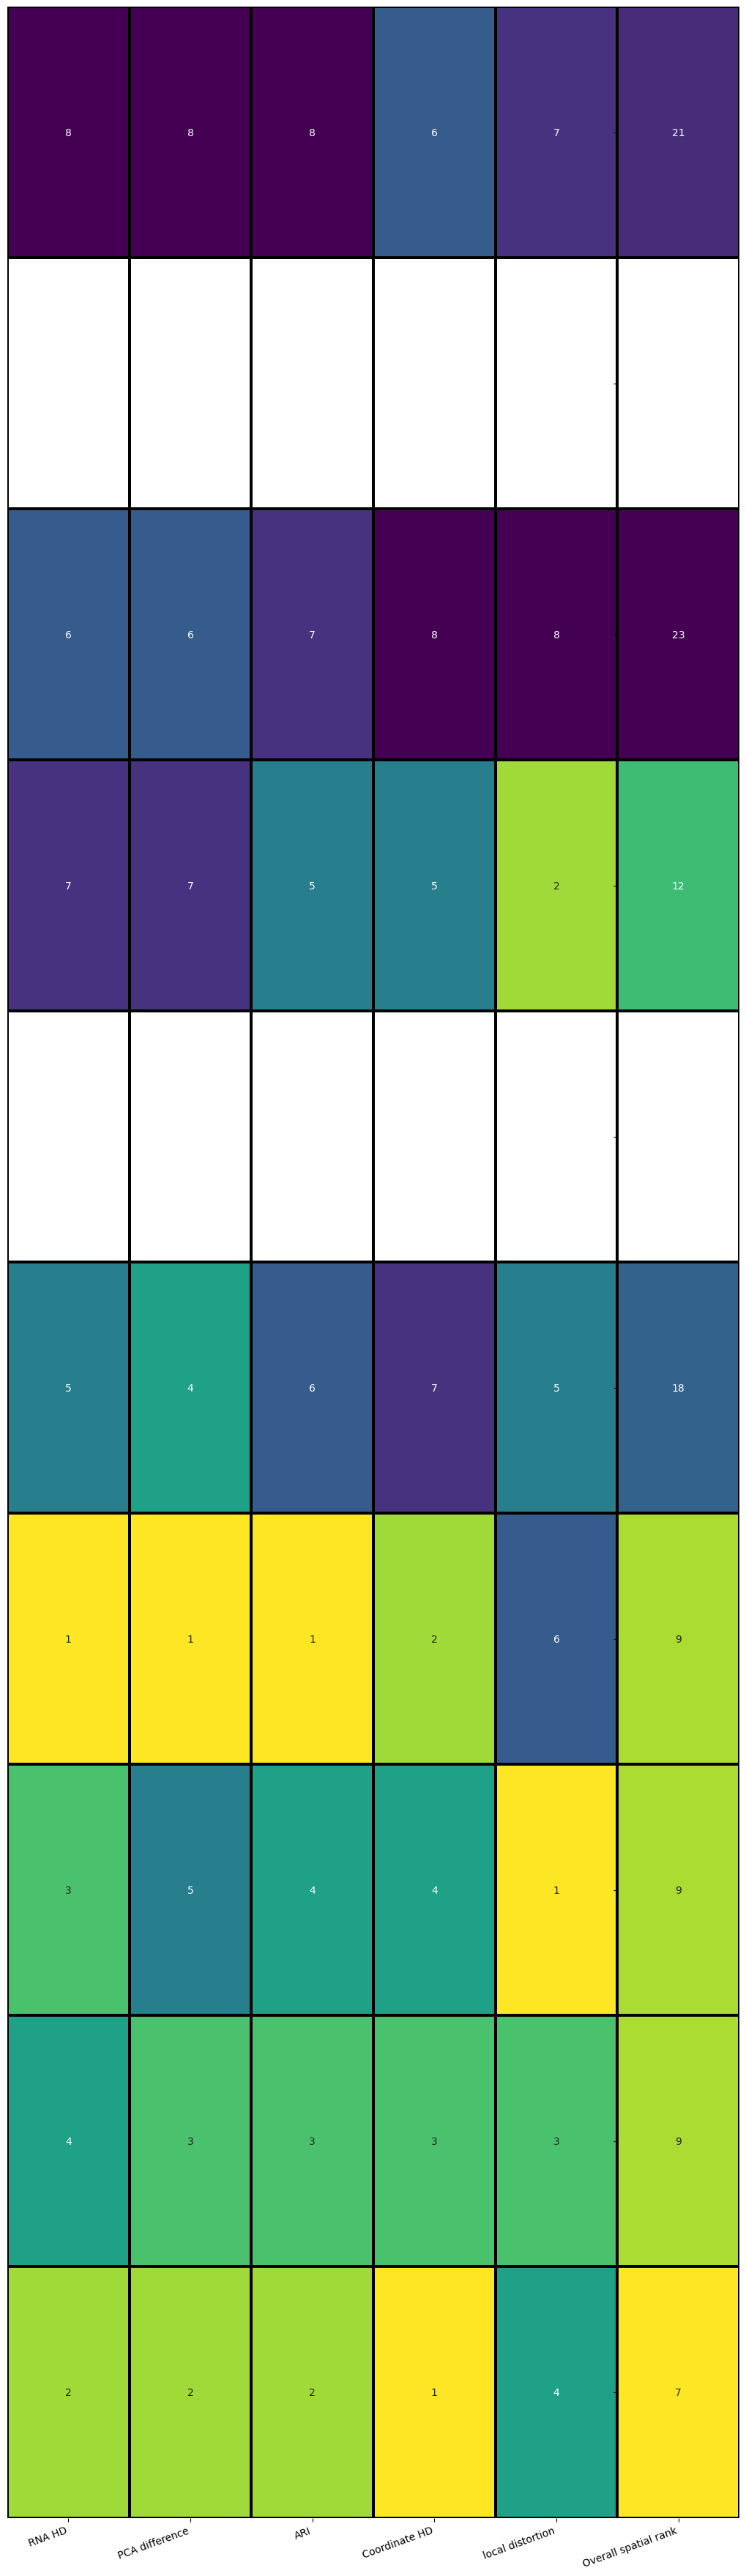

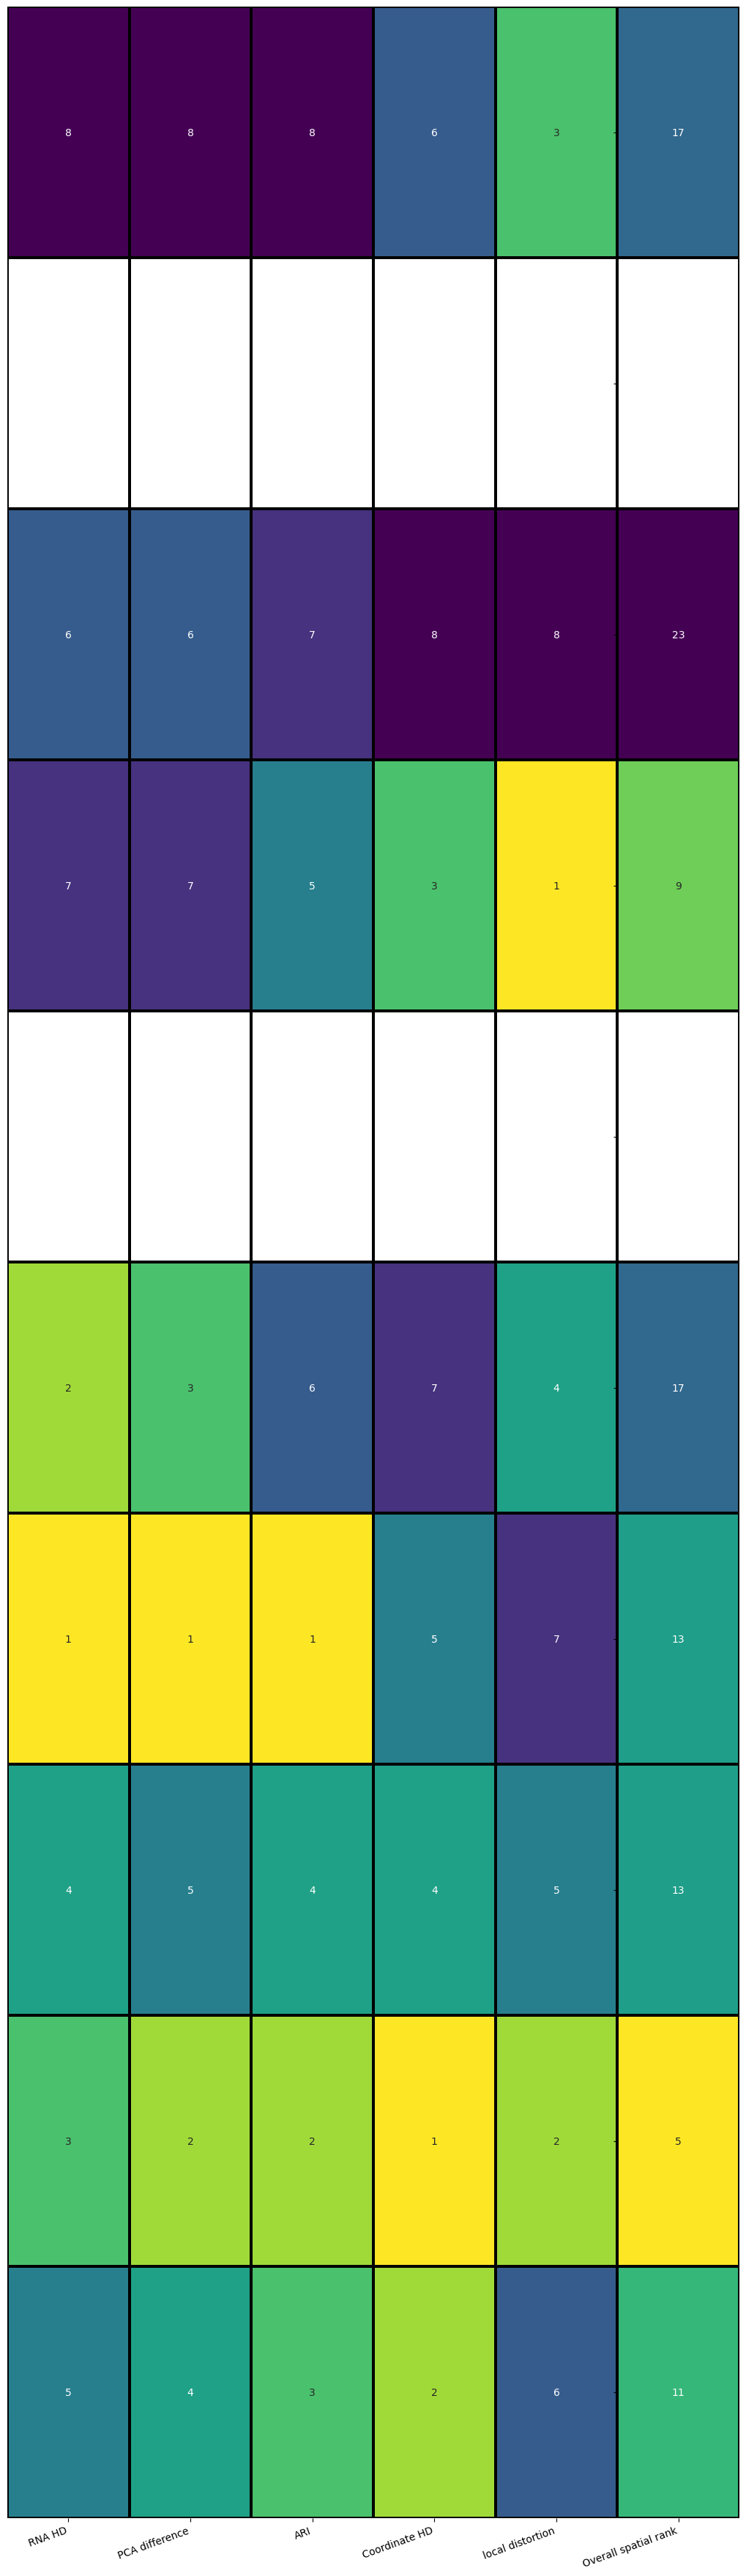

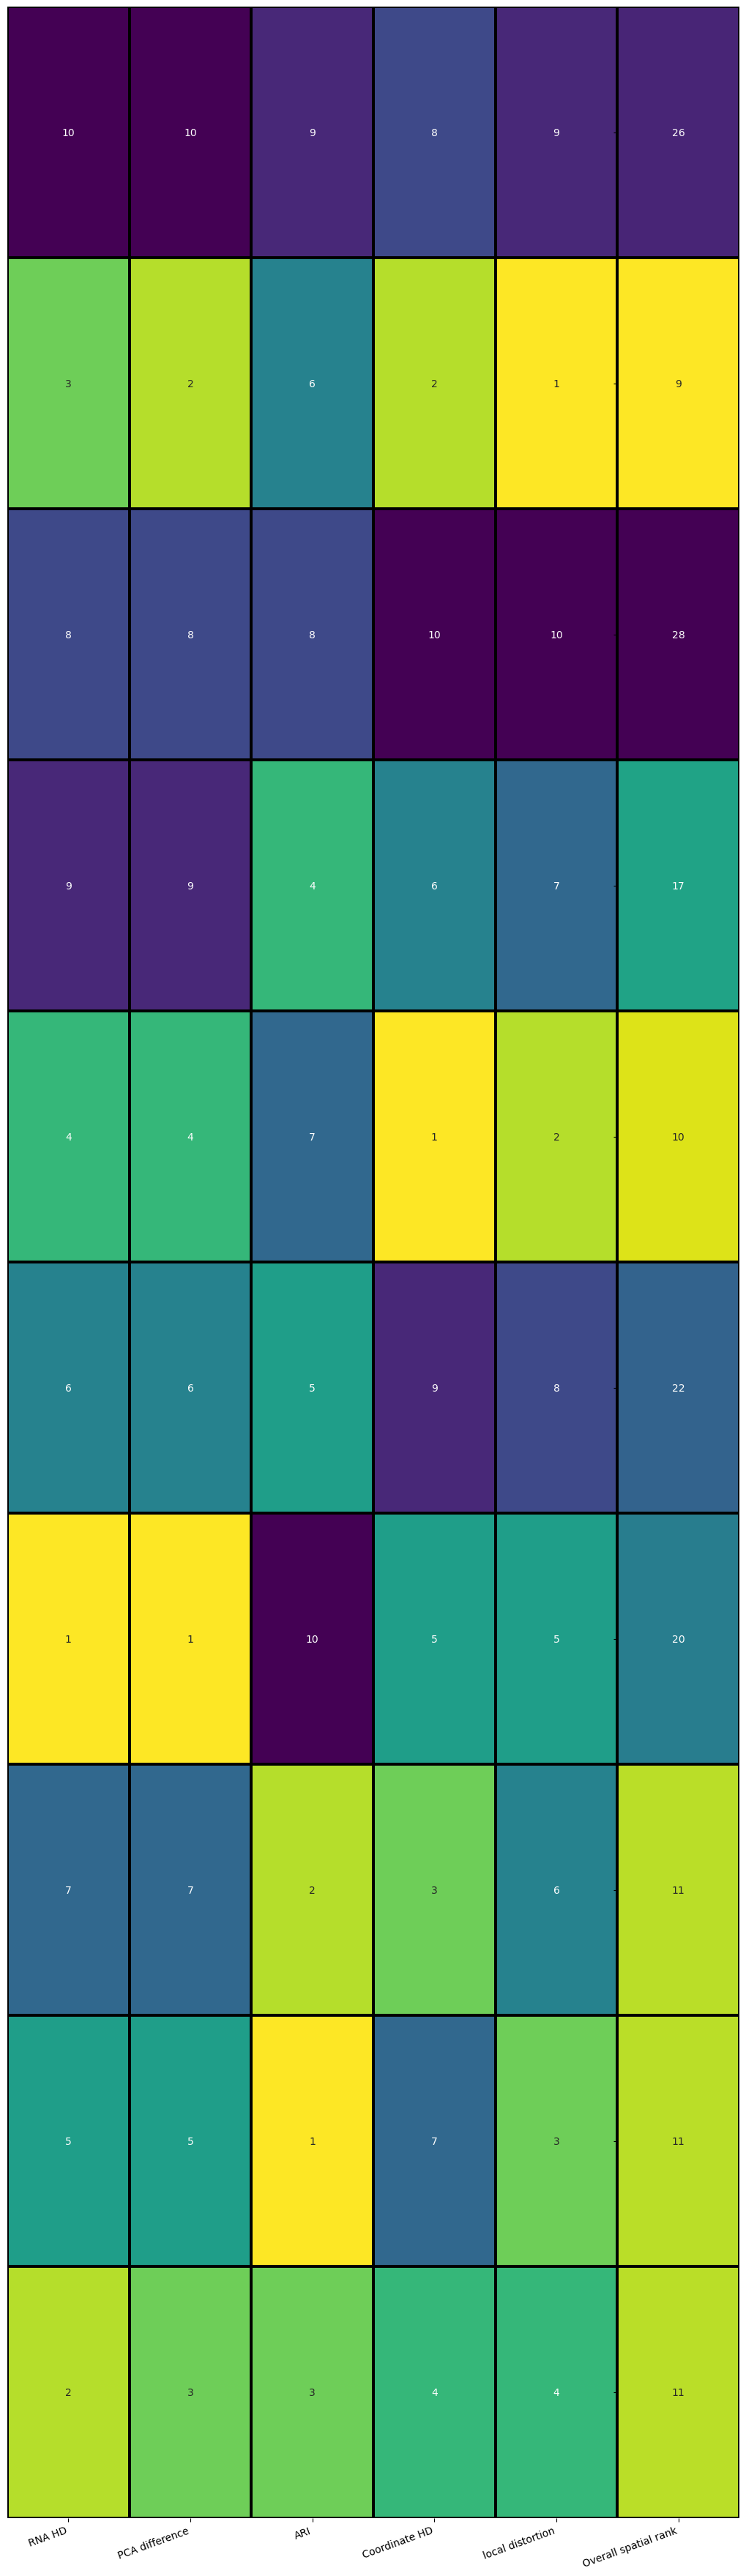

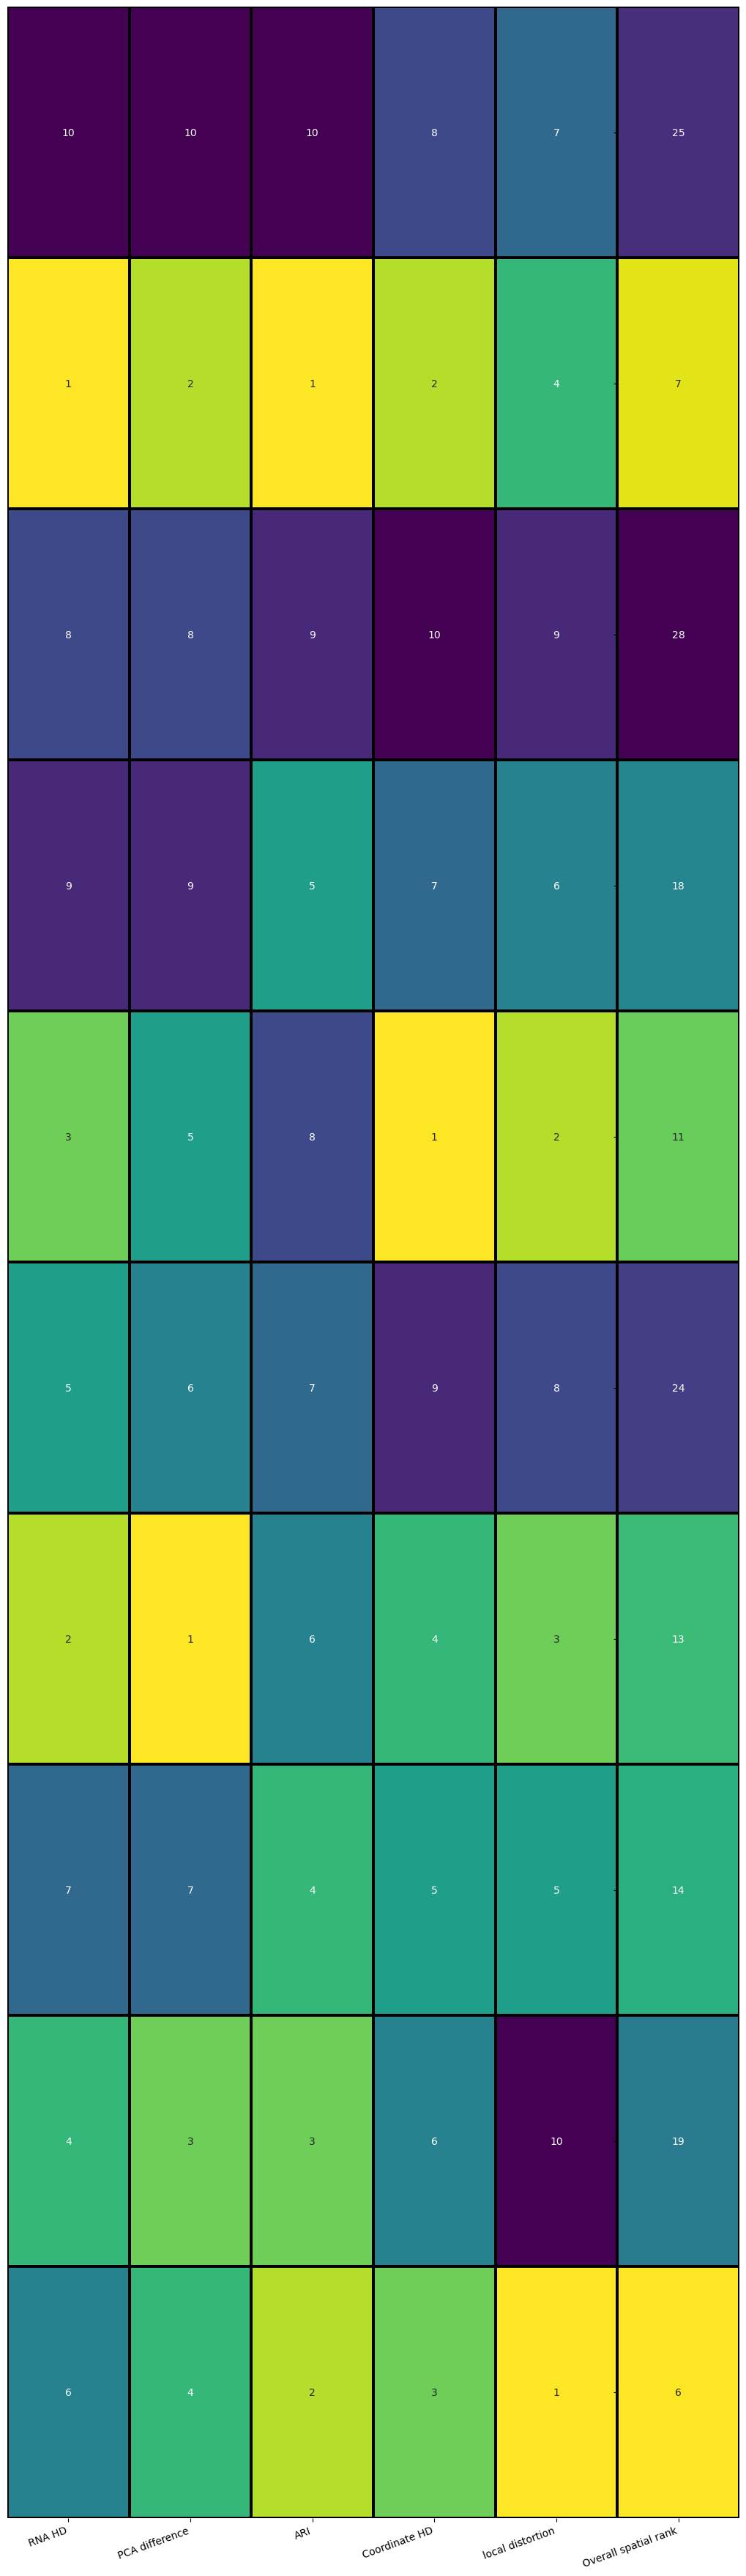

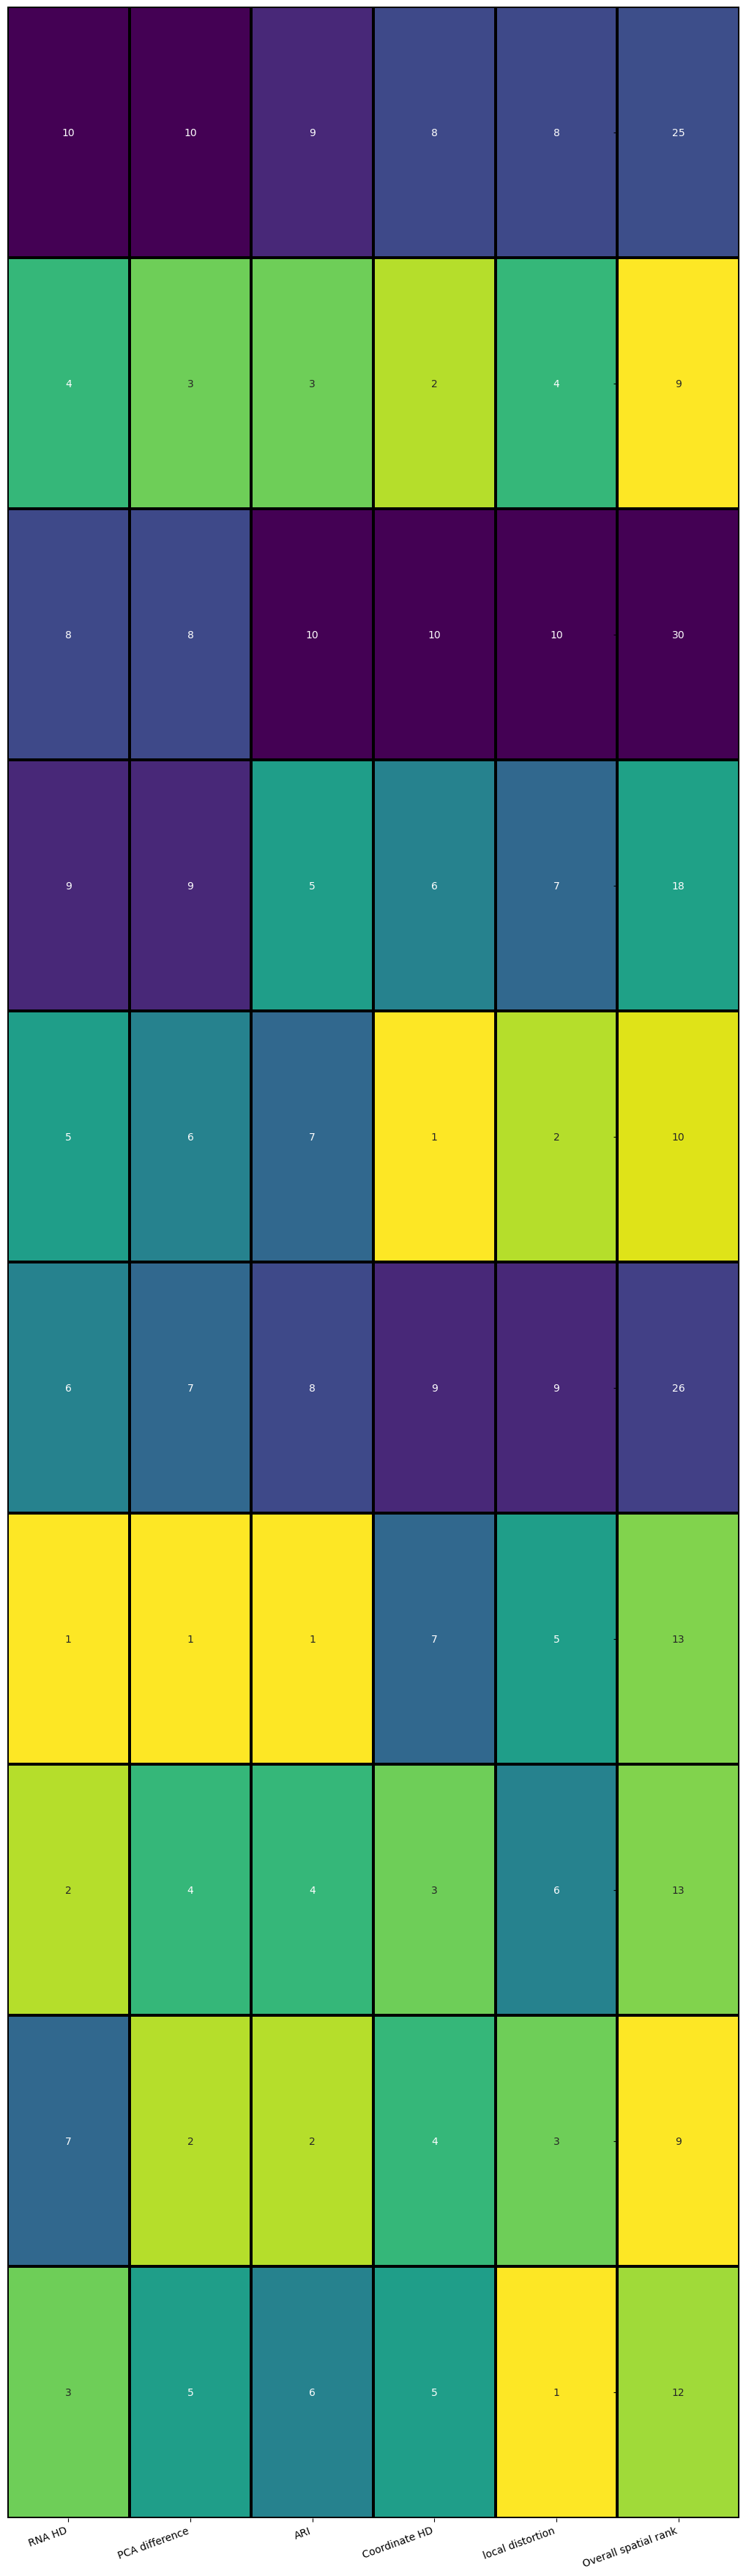

In [23]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
dataset = 'visium_HD_brain'
for dataset in rank_df['dataset'].unique():
#dataset = 'visium_like_complex'

    metrics_rank = [
        'ari_recomputed_pca_rank',              # higher is better
        'transcriptomic_distance_median_rank',  # lower is better
        'coord_distance_median_rank',           # lower is better
        'pca_mean_diff_median_rank',            # lower is better
        'mse_median_rank'                       # lower is better
    ] 
    
    # method_order = [
    #     'scsampler_transcriptomic',
    #     'geo_transcriptomic',
    #     'leverage_pca',
    #     'leverage',
    #     'scsampler_coord',
    #     'geo_coords',
    #     'rasp_scsampler',
    #     'rasp_geo',
    #     'rasp_leverage',
    #     'uniform'
    # ]
    method_order = [
        'scsampler_transcriptomic',
        'scsampler_coord',
        'rasp_scsampler',
        'geo_transcriptomic',
        'geo_coords',
        'rasp_geo',
        'leverage',
        'leverage_pca',
        'rasp_leverage',
        'uniform'
    ]
    
    column_order = [
    'transcriptomic_distance_median_rank',
    'pca_mean_diff_median_rank',
    'ari_recomputed_pca_rank',
    'coord_distance_median_rank',
    'mse_median_rank',
    'overall_spatial_rank']
    
    x_tick_labels = [
        'RNA HD',
        'PCA difference',
        'ARI',
        'Coordinate HD',
        'local distortion',
        'Overall spatial rank'
    ]
    
    
    metrics_to_plot = metrics_rank + ['overall_spatial_rank']
    sub = rank_df[rank_df['dataset'] == dataset].copy()
    
    # Set method as categorical for custom order
    sub['method'] = pd.Categorical(sub['method'], categories=method_order, ordered=True)
    # Set index and sort
    sub = sub.set_index('method').loc[method_order]
    sub[metrics_to_plot] = sub[metrics_to_plot].replace(0, np.nan)
    sub = sub[column_order]
    
    
    #sub = sub[metrics_to_plot]
    
    
    # Split data
    metric_part = sub.iloc[:,0:2] # the RNA parts 
    spatial_metric_part = sub.iloc[:, 2:-1]  # all except 'rank_sum'
    rank_sum_part = sub.iloc[:, [-1]]  # just 'rank_sum'
    
    # Create figure with two heatmaps side by side
    fig = plt.figure(figsize=(10, 35))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,3, 1],wspace = 0)  # wider metrics, narrow rank_sum
    
    # Left heatmap: rna metrics
    ax0 = plt.subplot(gs[0])
    sns.heatmap(metric_part, 
                annot=True, 
                cmap="viridis_r", 
                cbar=False, 
                linewidth=1.5, 
                linecolor='black',
                ax=ax0)
    ax0.set_xticklabels(x_tick_labels[0:2], rotation=20, ha='right')
    ax0.set_yticklabels([])
    ax0.tick_params(axis='y', left=False)
    ax0.set_ylabel('')
    
    # ax_spacer = plt.subplot(gs[1])
    # ax_spacer.axis('off')
    
    # middle heatmap: rank_sum
    ax1 = plt.subplot(gs[1],sharey = ax0)
    sns.heatmap(spatial_metric_part, 
                annot=True, 
                cmap="viridis_r", 
                cbar=False, 
                linewidth=1.5, 
                linecolor='black',
                ax=ax1)
    ax1.set_xticklabels(x_tick_labels[2:-1], rotation=20, ha='right')
    ax1.set_yticklabels([])
    ax1.tick_params(axis='y', left=False)
    ax1.set_ylabel('')
    
    #Right heatmamp: the rank sum or overall spatial score 
    ax2 = plt.subplot(gs[2],sharey = ax0)
    sns.heatmap(rank_sum_part,
               annot = True,
               cmap = 'viridis_r',
               cbar = False,
               linewidth = 1.5,
               linecolor = 'black',
               ax = ax2)
    ax2.set_xticklabels([x_tick_labels[-1]],rotation = 20,ha = 'right')
    ax2.set_yticklabels([])
    ax2.set_ylabel('')
    
    plt.tight_layout(pad = 0)
    plt.show()
    
    
    fig.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{dataset}_rank_heatmap_ordered_by_algorithm.svg', 
                format='svg', dpi=300)

In [11]:
import matplotlib.gridspec as gridspec

In [15]:
sub.iloc[:, 2:-1]

,ari_recomputed_pca_rank,coord_distance_median_rank,mse_median_rank
method,,,
scsampler_transcriptomic,5.0,8.0,5.0
scsampler_coord,NaN,NaN,NaN
rasp_scsampler,1.0,7.0,7.0
geo_transcriptomic,3.0,6.0,2.0
geo_coords,NaN,NaN,NaN
rasp_geo,8.0,5.0,4.0
leverage,7.0,4.0,1.0
leverage_pca,2.0,3.0,8.0
rasp_leverage,6.0,2.0,3.0
